Bouyancy budget for marshall and Radko doesn't quite hold

Best to start simple then!

\begin{equation}
\overline{v}\frac{\partial \overline{T}}{\partial y} + \overline{w}\frac{\partial \overline{T}}{\partial z} + \frac{\partial \overline{v'T'}}{\partial y} + \frac{\partial \overline{w'T'}}{\partial z}  = Q + Diff
\end{equation}

***

To test this i'll start with my control case (3 day tau)

* Will need 3 day eddy output for VWT
* Q 
* Model diffusion



In [5]:
import matplotlib
matplotlib.matplotlib_fname()

u'/home/helenb/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc'

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
import math
import glob
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
sys.path.append('../../../python_functions/')
import useful as hb
import SG
%install_ext https://raw.githubusercontent.com/SiggyF/notebooks/master/pep8_magic.py
%load_ext pep8_magic
%matplotlib inline

Installed pep8_magic.py. To use it, type:
  %load_ext pep8_magic


In [10]:
def ddz_cgrid_centered(q,DZ):
    """Vertical second-order centered difference on the c grid"""
    out = np.zeros(q.shape)
        # second order for interior                                             
    out[1:-1,:] = (q[:-2,:] - q[2:,:]) / DZ[1:-1,:]

    # first order for the top and bottom                                    
    out[0,:] = (q[0,:] - q[1,:]) / DZ[0,:]
    out[-1,:] = (q[-2,:] - q[-1,:]) / DZ[-1,:]

    return out

def ddy_cgrid_centered(q,dy):
    """Merdional second-order centered difference on the c grid"""
    out = np.zeros(q.shape)
    out[:,1:ny-1] = (q[:,2:] - q[:,:ny-2]) / dy
    out[:,0] = (q[:,1] - q[:,0]) / dy
    out[:,-1] = (q[:,-1] - q[:,-2]) / dy
    return out

In [11]:
Full='N' # 9 Pannels isn't ideal for presentations N option give 4 plots

In [45]:
if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
# path = '/hpcdata/scratch/hb1g13/NchannelFlat'
path = '/noc/msm/scratch/students/hb1g13/Mobilis'
path = '/home/helenb/NOCS/noc/msm/scratch/students/hb1g13/Mobilis'
Figletter = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ',
             'f) ', 'g) ', 'h) ', 'i) ']
pi = math.pi
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r $^oC$ %'
else:
    fmt = '%r $^oC$'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = path+'/'+str(tau[i])+'daynokpp/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)
# Constant Parameters
alpha = 2.000000E-04
G = -9.81
rho_0 = 1000
C_p = 3985.0
Res = 5000
Ly = 2000e3
Lx = 1000e3 
H = 2985 
nz = 30 
# Dimensions
nx = np.round(Lx/Res)
ny = np.round(Ly/Res)
dx = np.ones(nx)*Res
dy = np.ones(ny)*Res
x = (np.cumsum(dx)-dx/2)-Lx/2
y = (np.cumsum(dy)-dy/2)-Ly/2
[Y, X] = np.meshgrid(y, x) 
Q = 10*(np.sin(Y*(3*pi/Ly)))
Q[:, ny-(np.round(ny/6)):ny] = 0
Q = np.zeros(np.shape(Q))
Q[:,0:int(5*ny/36)] = -11*(np.sin(Y[:,0:int(5*ny/36)]*(pi/Y[1,int(5*ny/36)])))
Q[:,int(5*ny/36):int(20*ny/36)] = 10*(np.sin((Y[:,int(5*ny/36):int(20*ny/36)]-Y[1,int(5*ny/36)])*(pi/(5*Y[1,int(15*ny/36)]))))
Q[:,int(20*ny/36):int(30*ny/36)] = -10.5*(np.sin((Y[:,int(20*ny/36):int(30*ny/36)]-Y[1,int(20*ny/36)])*(0.8*pi/(Y[1,int(10*ny/36)]))))
Q = Q+(-sum(Q)/(ny*nx)) 
Psipred = -(Q[1, :])/(rho_0*C_p)
# Grid parameters
gridfilepath = path+'/'+str(tau[0])+'daynokpp/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc','r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Yc = file2.variables['Y'][:]
dz = Zp[0:-1]-Zp[1::][:]
dA = dz*5000
Zmatrix = np.zeros((len(Z),len(Yc)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
Zmatrix = np.apply_along_axis(np.multiply,0,Zmatrix,dz)
yr = Yc[0:-70]/1000  # y range
y = Yc/1000

\begin{equation}
\underbrace{\overline{v}  \frac{\partial \overline{T}}{\partial y } + \frac{\partial (\overline{T_z} \overline{w'T' /\overline{T_y}})}{\partial y} + \overline{w}\frac{\partial \overline{T}}{\partial z } +  \frac{\partial \overline{w'T'}}{\partial z }}_\text{ROC avective terms} = \underbrace{\frac{\partial B}{\partial z}}_\text{Air-sea fluxes} - \underbrace{\frac{\partial \overline{v'T'}-\frac{w'T'}{Sp}}{\partial y }}_\text{Diabatic eddies} 
\end{equation}

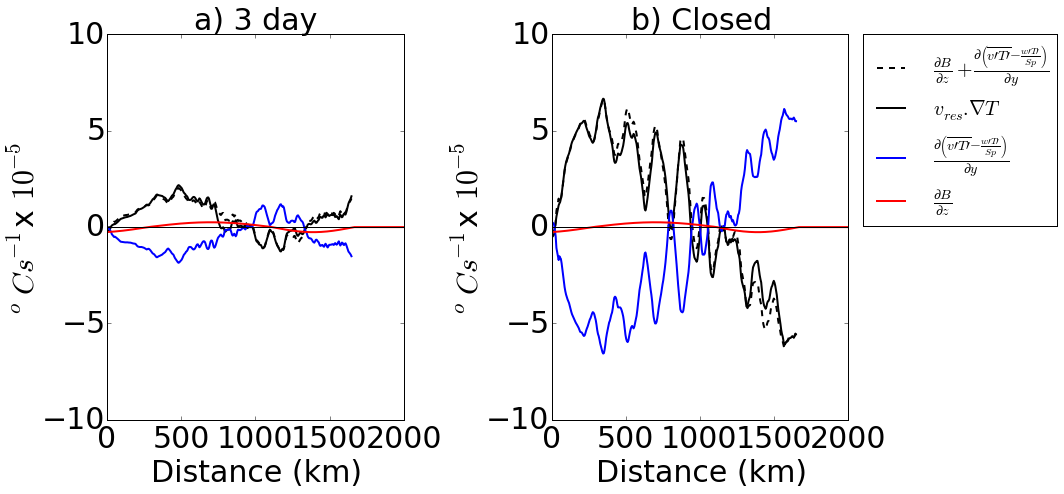

In [52]:
fig=plt.figure(figsize=(12.5,12.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:]
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:].mean(axis=0)
    TTav = filetav.variables['THETA'][:].mean(axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav = hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Ty = ddy_cgrid_centered(TTav.mean(axis=2),5000)
    Tz = ddz_cgrid_centered(TTav.mean(axis=2),Zmatrix)
    Tz[np.round(Tz,5) == 0]=np.nan
    Ty[np.round(Ty,5) == 0]=np.nan
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty
    WTMz = WTav.mean(axis=2)*Tz
    VTpy = ddy_cgrid_centered(VTp.mean(axis=2),5000)
    WTpz = ddz_cgrid_centered(WTp.mean(axis=2),Zmatrix)
    # Diabatic Eddy
    D = VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dy = -ddy_cgrid_centered(D,5000)*Zmatrix
    # ROC
    Vstar = ddy_cgrid_centered(Tz*WTp.mean(axis=2)/(Ty),5000) 
    ROC = ((WTpz+Vstar+WTMz+VTMy))*Zmatrix
    AD =Vstar + WTpz
    Mean = WTMz +VTMy
    # x10^5 to make units less crazy!
    if Full == 'N':
        ax = fig.add_subplot(2, 2, i+1)
        plt.plot(yr,(Psipred[0:-70]+SG.savitzky_golay(np.nansum(Dy[:,:],axis=0)[0:-70],15,1))*10**5,'--k',linewidth=2)
        plt.plot(yr,SG.savitzky_golay(np.nansum(ROC[:,:],axis=0)[0:-70],15,1)*10**5,'k',linewidth=2)
        plt.plot(yr,-SG.savitzky_golay(np.nansum(Dy[:,:],axis=0)[0:-70],15,1)*10**5,'b',linewidth=2)
        plt.plot(y,Psipred*10**5,'r',linewidth=2)
        plt.plot(y,Psipred*10**-9,'k',linewidth=1)  # 0 Line
        plt.ylim(-10.0,10)
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day',fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]),fontsize=30)
    ax.set_xlabel('Distance (km)',fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-5}$',fontsize=30)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r' $\frac{\partial B}{\partial z} + \frac{\partial \left( \overline{v\prime T\prime}-\frac{w\prime T\prime}{Sp}\right)}{\partial y }$',r' $v_{res}.\nabla T$',r' $\frac{\partial \left( \overline{v\prime T\prime}- \frac{w\prime T\prime}{Sp}\right)}{\partial y }$',r' $\frac{\partial B}{\partial z}$'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

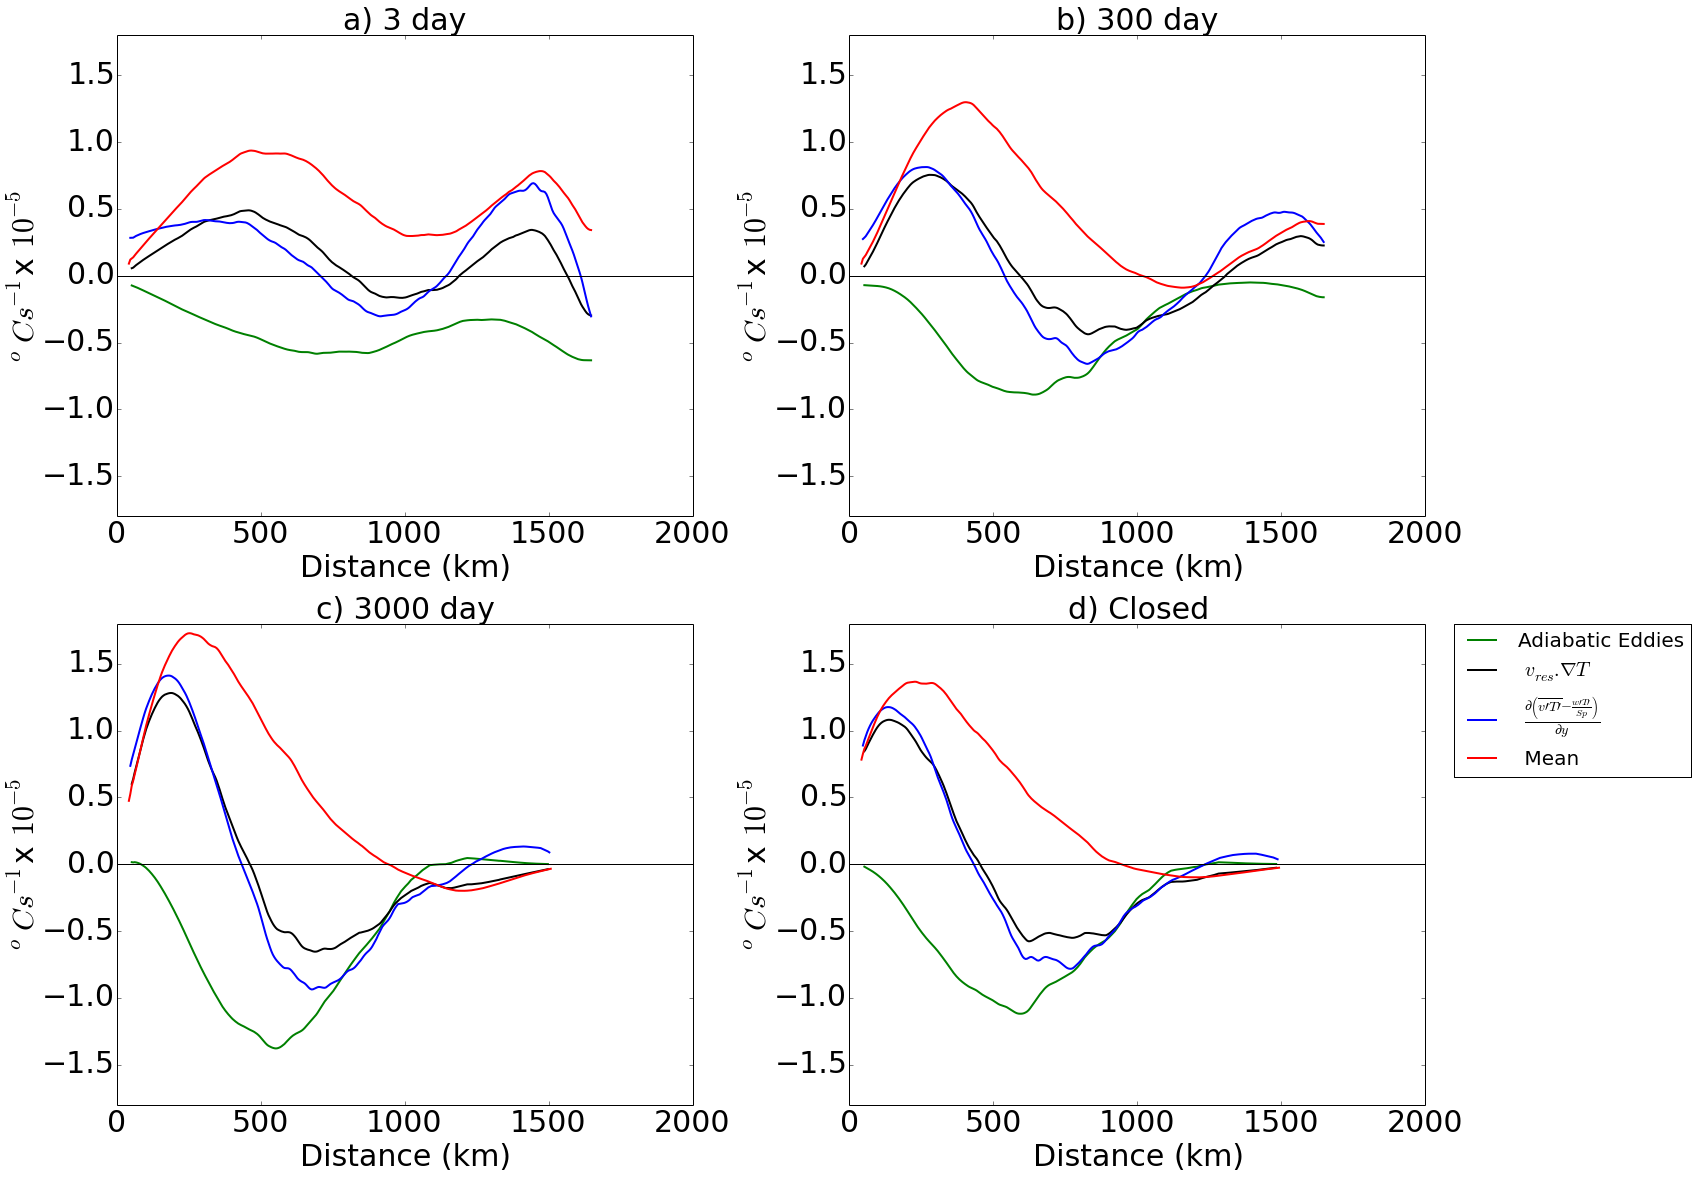

In [14]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:]
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:].mean(axis=0)
    TTav = filetav.variables['THETA'][:].mean(axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav = hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    Tz[np.round(Tz,3) == 0]=np.nan
    Ty[np.round(Ty,3) == 0]=np.nan
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty/5000
    WTMz = WTav.mean(axis=2)*Tz
    VTpz, VTpy = np.gradient(VTp.mean(axis=2),5000)
    WTpz, WTpy = np.gradient(WTp.mean(axis=2))
    WTMZ = -WTMz/Zmatrix
    WTpZ = -WTpz/Zmatrix
    # Load Variables 
    B = ((WTpZ+WTMZ+VTMy)*G*alpha)*Zmatrix
    # Diabatic Eddy
    D = VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dz, Dy = np.gradient(D)
    Dy = (Dy/5000)*Zmatrix
    # ROC
    Vstar = np.gradient(5000*Tz*WTp.mean(axis=2)/(Zmatrix*Ty),5000)[1]
    Vstarz = np.gradient(Vstar,5000)[1]   
    ROC = ((WTpZ+Vstarz+WTMZ+VTMy))*Zmatrix
    Mean = (WTMZ+VTMy)*Zmatrix
    # x10^5 to make units less crazy!
    if Full == 'N':
        ax = fig.add_subplot(2, 2, i+1)
        plt.plot(yr,(SG.savitzky_golay(np.nansum(((Vstarz+WTpZ)*Zmatrix)[0:5,:],axis=0)[0:-70],15,1))*10**5,'g',linewidth=2)
        plt.plot(yr,SG.savitzky_golay(np.nansum(ROC[0:5,:],axis=0)[0:-70],15,1)*10**5,'k',linewidth=2)
        plt.plot(yr,-SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1)*10**5,'b',linewidth=2)
        plt.plot(yr,SG.savitzky_golay(np.nansum(Mean[0:5,:],axis=0)[0:-70],15,1)*10**5,'r',linewidth=2)
        plt.plot(y,Psipred*10**-9,'k',linewidth=1)  # 0 Line
        plt.ylim(-1.8,1.8)
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day',fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]),fontsize=30)
    ax.set_xlabel('Distance (km)',fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-5}$',fontsize=30)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'Adiabatic Eddies',r' $v_{res}.\nabla T$',r' $\frac{\partial \left( \overline{v\prime T\prime}- \frac{w\prime T\prime}{Sp}\right)}{\partial y }$',r' Mean'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

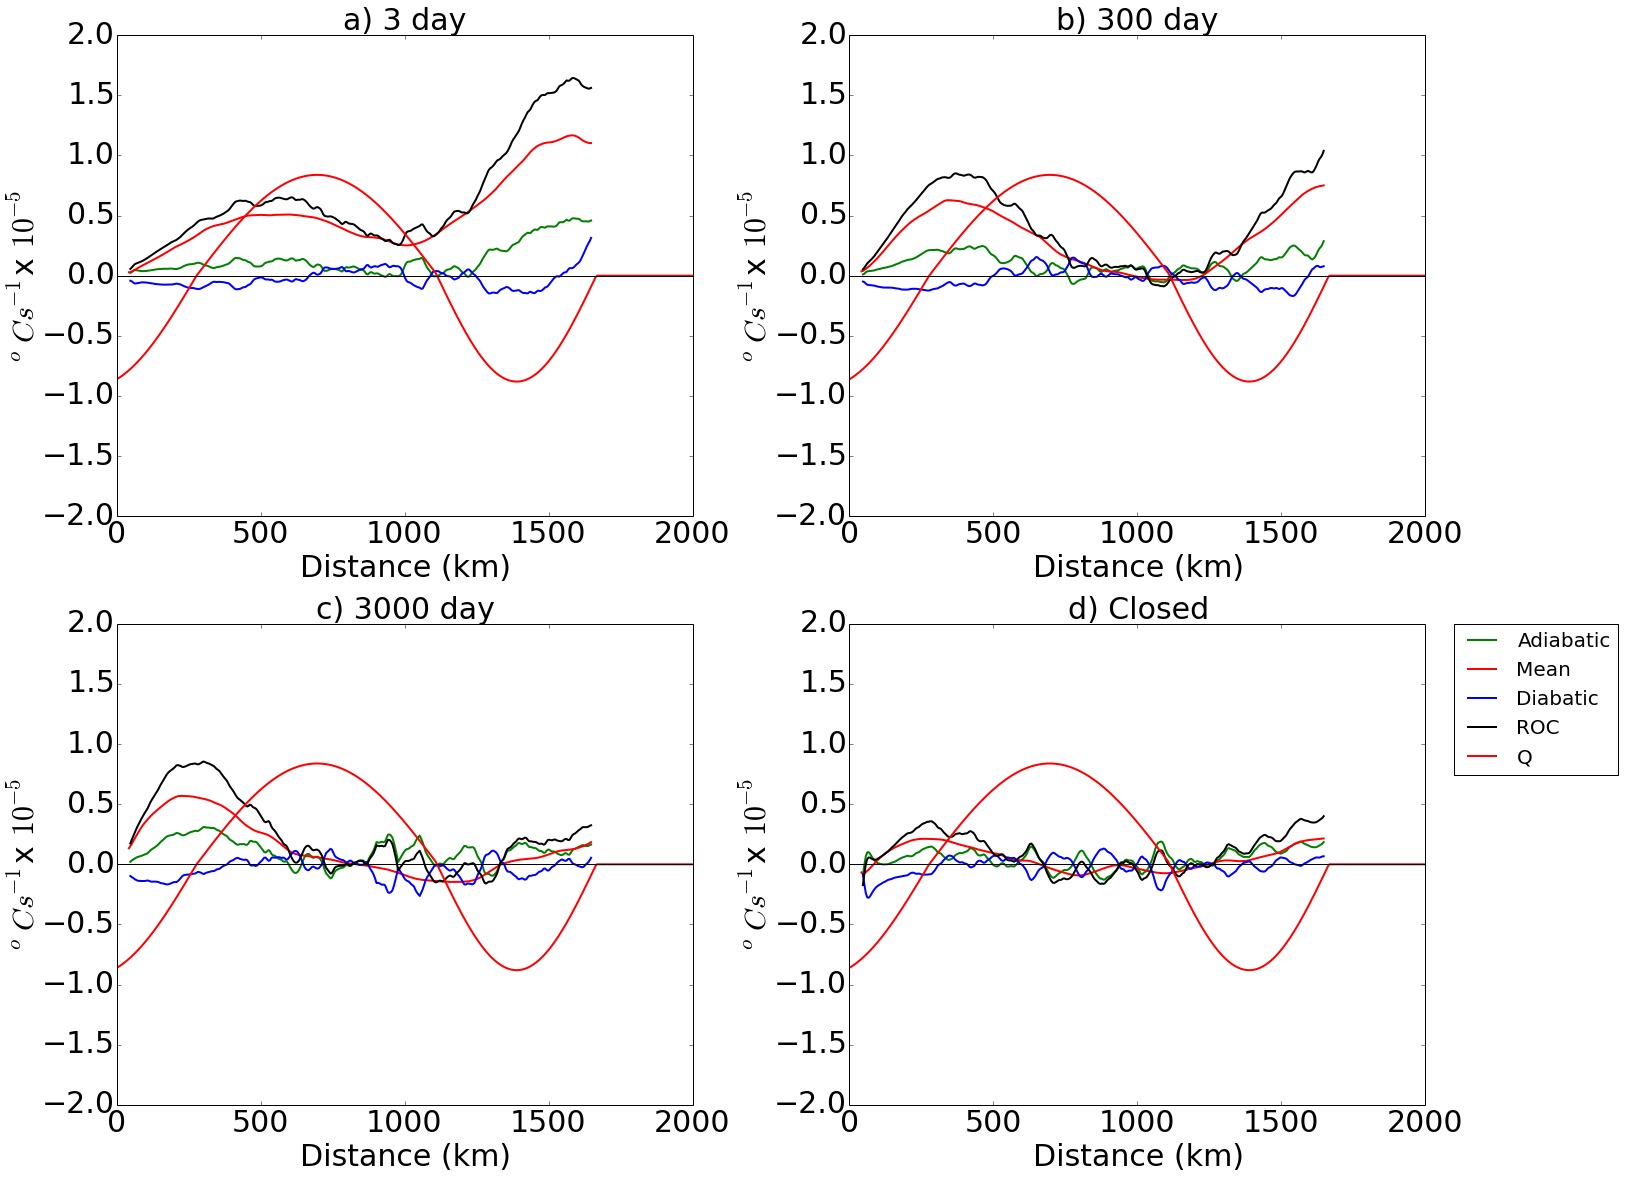

In [27]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:]
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:].mean(axis=0)
    TTav = filetav.variables['THETA'][:].mean(axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    else: 
        TTav = TTav - 4.0
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav = hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    Tz[np.round(Tz,3) == 0]=np.nan
    Ty[np.round(Ty,3) == 0]=np.nan
    Tz = Tz/Zmatrix
    Ty = Ty/5000
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty
    WTMz = WTav.mean(axis=2)*Tz
    Mean = WTMz+VTMy
    Vstar = np.gradient(Tz*WTp.mean(axis=2)/(Ty),5000)[1] 
    WTpz = np.gradient(WTp.mean(axis=2))[0]
    WTpZ = WTpz/Zmatrix
    AdEd = Vstar + WTpZ
    VTpy = np.gradient(VTp.mean(axis=2),5000)[1]
    # Diabatic Eddy
    D = VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dy = np.gradient(D,5000)[1]
    # ROC
    Vstar = np.gradient(Tz*WTp.mean(axis=2)/(Ty),5000)[1] 
    ROC = (WTpZ+Vstar+WTMz+VTMy)
    if Full == 'N':
        ax = fig.add_subplot(2, 2, i+1)
        plt.plot(yr,SG.savitzky_golay(np.nansum(AdEd[:,:],axis=0)[0:-70],15,1)*10**6,'g',linewidth=2)
        plt.plot(yr,SG.savitzky_golay(np.nansum(Mean[:,:],axis=0)[0:-70],15,1)*10**6,'r',linewidth=2)
        plt.plot(yr,SG.savitzky_golay(np.nansum(Dy[:,:],axis=0)[0:-70],15,1)*10**6,'b',linewidth=2)
        plt.plot(yr,SG.savitzky_golay(np.nansum(ROC[:,:],axis=0)[0:-70],15,1)*10**6,'k',linewidth=2)
        plt.plot(y,Psipred/H*10**6,'r',linewidth=2)
        plt.plot(y,Psipred*10**-9,'k',linewidth=1)
        plt.ylim(-2.,2.)
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day',fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]),fontsize=30)
    ax.set_xlabel('Distance (km)',fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-5}$',fontsize=30)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'Adiabatic',r'Mean','Diabatic','ROC','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

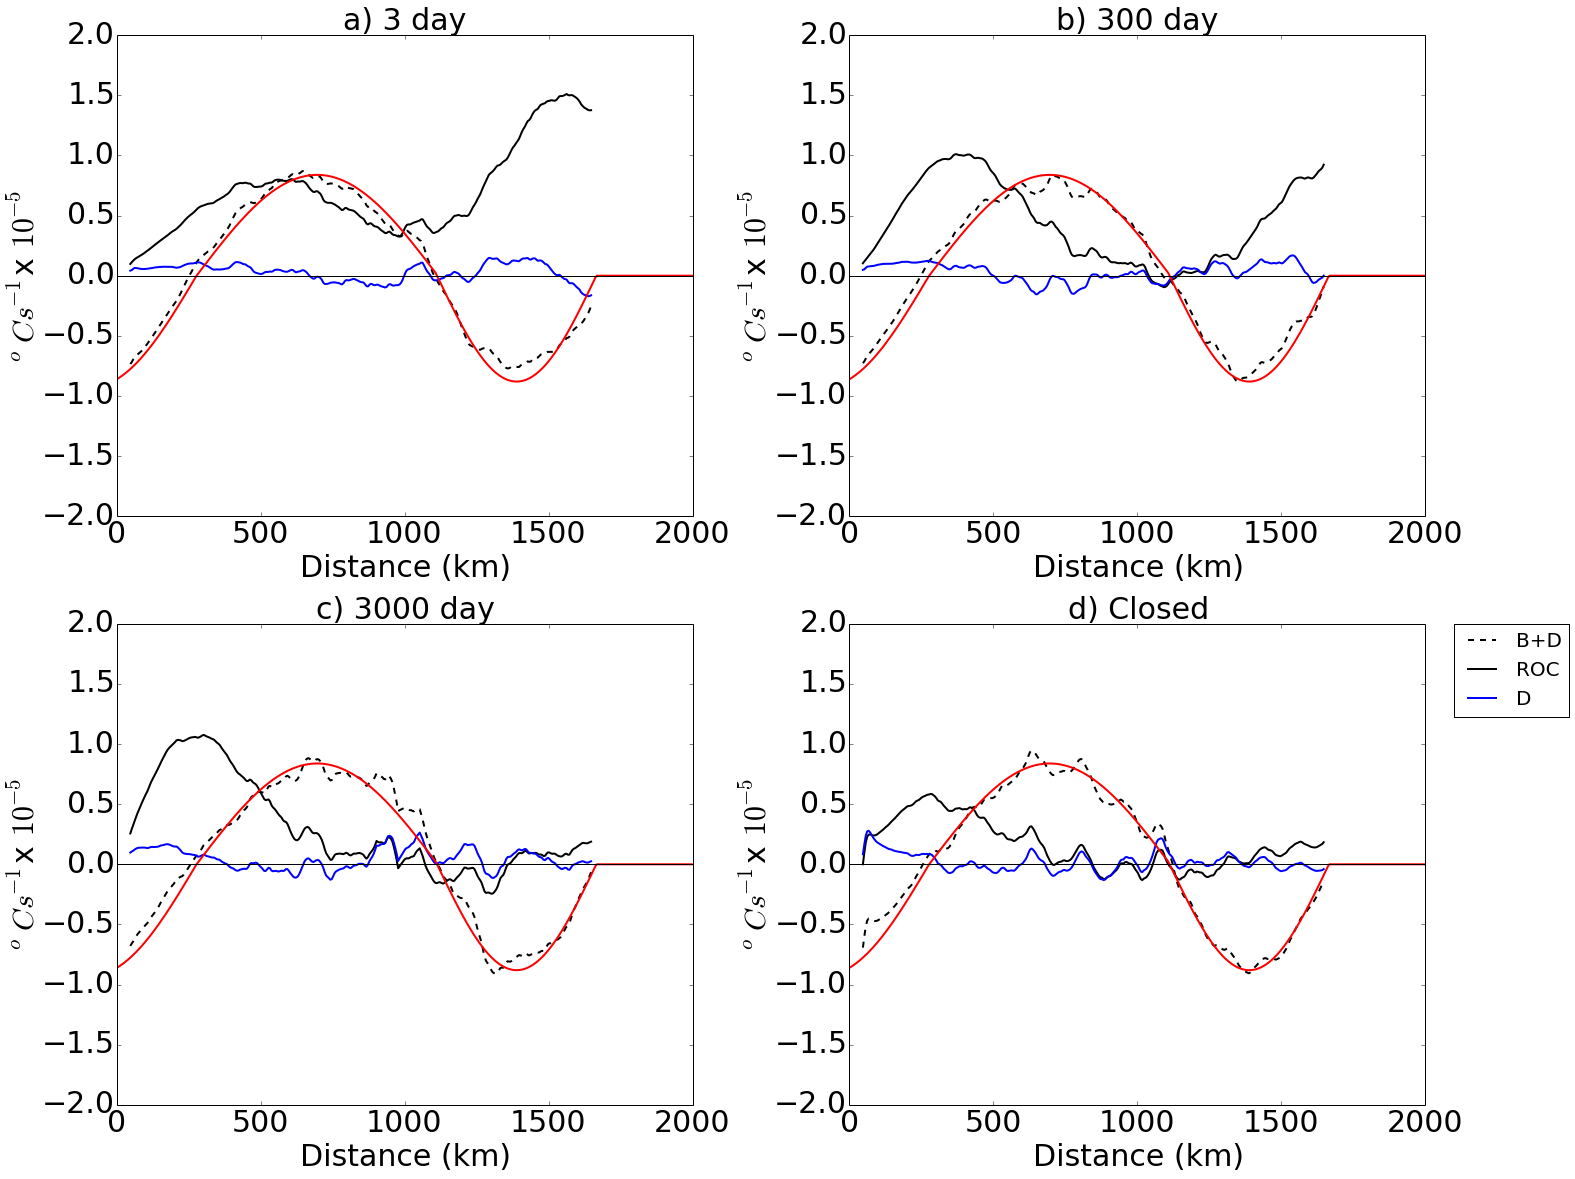

In [115]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:]
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:].mean(axis=0)
    TTav = filetav.variables['THETA'][:].mean(axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav = hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    Tz[np.round(Tz,3) == 0]=np.nan
    Ty[np.round(Ty,3) == 0]=np.nan
    Tz = Tz/Zmatrix
    Ty = Ty/5000
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty
    WTMz = WTav.mean(axis=2)*Tz
    VTpy = np.gradient(VTp.mean(axis=2),5000)[1]
    WTpz = np.gradient(WTp.mean(axis=2))[0]
    WTpZ = WTpz/Zmatrix
    # Diabatic Eddy
    D = VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dy = -np.gradient(D,5000)[1]
    # ROC
    Mean = WTMZ+VTMy
    Vstar = np.gradient(Tz*WTp.mean(axis=2)/(Ty),5000)[1] 
    ROC = (WTpZ+Vstar+WTMZ+VTMy)
    if Full == 'N':
        ax = fig.add_subplot(2, 2, i+1)
        plt.plot(yr,(Psipred[0:-70]+SG.savitzky_golay(np.nansum(Dy[:,:],axis=0)[0:-70],15,1))*10**6,'--k',linewidth=2)
        plt.plot(yr,SG.savitzky_golay(np.nansum(ROC[:,:],axis=0)[0:-70],15,1)*10**6,'k',linewidth=2)
        plt.plot(yr,SG.savitzky_golay(np.nansum(Dy[:,:],axis=0)[0:-70],15,1)*10**6,'b',linewidth=2)
        plt.plot(y,Psipred*10**6,'r',linewidth=2)
        plt.plot(y,Psipred*10**-9,'k',linewidth=1)
        plt.ylim(-2.,2.)
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day',fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]),fontsize=30)
    ax.set_xlabel('Distance (km)',fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-5}$',fontsize=30)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'B+D',r'ROC','D'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

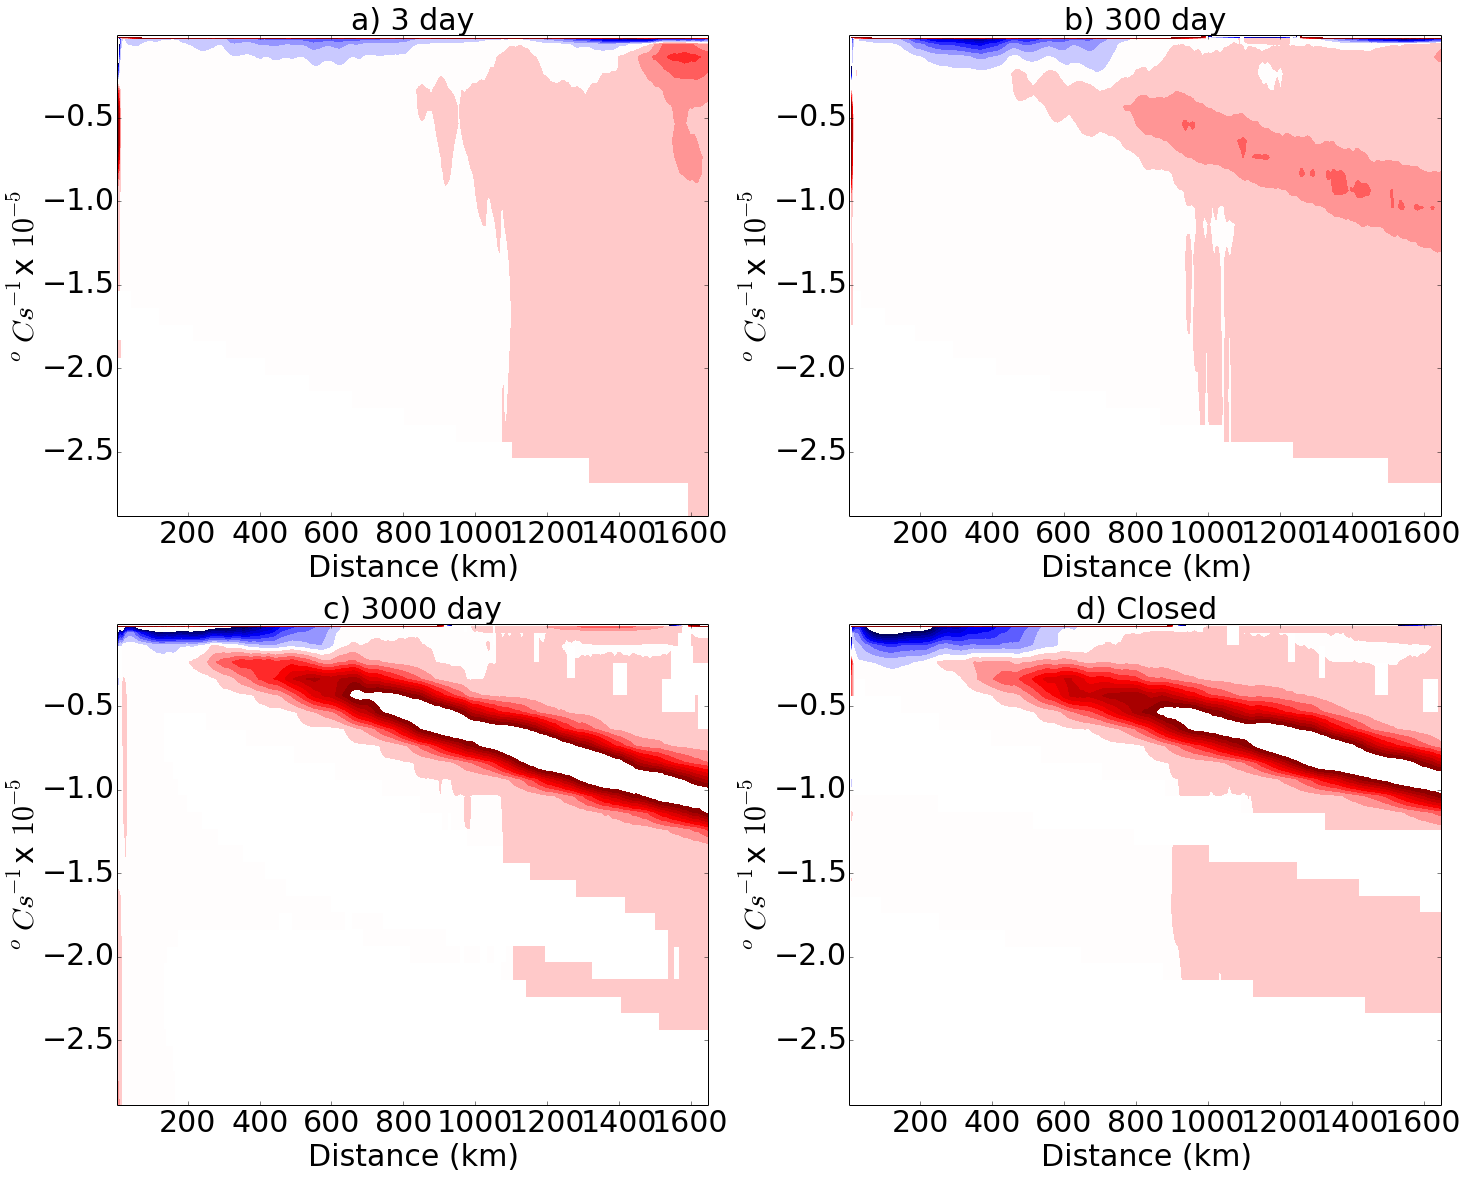

In [98]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:]
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:].mean(axis=0)
    TTav = filetav.variables['THETA'][:].mean(axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav = hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    Tz[np.round(Tz,4) == 0]=np.nan
    Ty[np.round(Ty,4) == 0]=np.nan
    Zmatrix = - Zmatrix
    Tz = Tz #/Zmatrix
    Ty = Ty #/ 5000
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty
    WTMz = WTav.mean(axis=2)*Tz
    VTpy = np.gradient(VTp.mean(axis=2),5000)[1]
    WTpz = np.gradient(WTp.mean(axis=2))[0]/Zmatrix
    WTMZ = WTMz
    WTpZ = WTpz
    # Diabatic Eddy
    D = VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dz, Dy = np.gradient(D)
    Dy = (Dy/5000)
    # ROC
    Mean = (WTMZ+VTMy )
    Vstar = Tz*WTp.mean(axis=2) 
    ADed =(WTpZ + Vstar*Tz )
    ROC =  (Mean + ADed)
    rlvls = np.arange(-2,2,0.2)
    if Full == 'N':
        ax = fig.add_subplot(2, 2, i+1)
        p = ax.contourf(yr, Z/1000, ROC[:,0:-70]*10**5, rlvls, cmap=plt.cm.seismic)  # Use b2r colourmap
        #plt.plot(yr,(Psipred[0:-70]-SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1))*10**5,'--k',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(ROC[0:5,:],axis=0)[0:-70],15,1)*10**5,'k',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1)*10**5,'b',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(ADed[0:5,:],axis=0)[0:-70],15,1)*10**5,'--r',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(Mean[0:5,:],axis=0)[0:-70],15,1)*10**5,'g',linewidth=2)
        #plt.plot(y,Psipred*10**5,'r',linewidth=2)
        #plt.plot(y,Psipred*10**-9,'k',linewidth=1)
        #plt.ylim(-1.0,1.8)
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day',fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]),fontsize=30)
    ax.set_xlabel('Distance (km)',fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-5}$',fontsize=30)
    ax.tick_params(labelsize=30)
#lgd=plt.legend([r'B+D',r'ROC','D'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

In [1]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:]
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:].mean(axis=0)
    TTav = filetav.variables['THETA'][:].mean(axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav = hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    Tz[np.round(Tz,4) == 0]=np.nan
    Ty[np.round(Ty,4) == 0]=np.nan
    Zmatrix = - Zmatrix
    Tz = Tz #/Zmatrix
    Ty = Ty #/ 5000
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty
    WTMz = WTav.mean(axis=2)*Tz
    VTpy = np.gradient(VTp.mean(axis=2),5000)[1]
    WTpz = np.gradient(WTp.mean(axis=2))[0]/Zmatrix
    WTMZ = WTMz
    WTpZ = WTpz
    # Diabatic Eddy
    D = VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dz, Dy = np.gradient(D)
    Dy = (Dy/5000)
    # ROC
    Mean = (WTMZ+VTMy )
    Vstar = Tz*WTp.mean(axis=2)/Ty 
    ADed =(WTpZ + Vstar )
    ROC =  (Mean + ADed)
    rlvls = np.arange(-3,3,0.21)
    if Full == 'N':
        ax = fig.add_subplot(2, 2, i+1)
        p = ax.contourf(yr, Z/1000, ADed[:,0:-70]*10**5, rlvls, cmap=plt.cm.seismic)  # Use b2r colourmap
        #plt.plot(yr,(Psipred[0:-70]-SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1))*10**5,'--k',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(ROC[0:5,:],axis=0)[0:-70],15,1)*10**5,'k',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1)*10**5,'b',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(ADed[0:5,:],axis=0)[0:-70],15,1)*10**5,'--r',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(Mean[0:5,:],axis=0)[0:-70],15,1)*10**5,'g',linewidth=2)
        #plt.plot(y,Psipred*10**5,'r',linewidth=2)
        #plt.plot(y,Psipred*10**-9,'k',linewidth=1)
        #plt.ylim(-1.0,1.8)
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day',fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]),fontsize=30)
    ax.set_xlabel('Distance (km)',fontsize=30)
    ax.set_ylabel(r'Depth (km)',fontsize=30)
    ax.tick_params(labelsize=30)
#lgd=plt.legend([r'B+D',r'ROC','D'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

NameError: name 'plt' is not defined

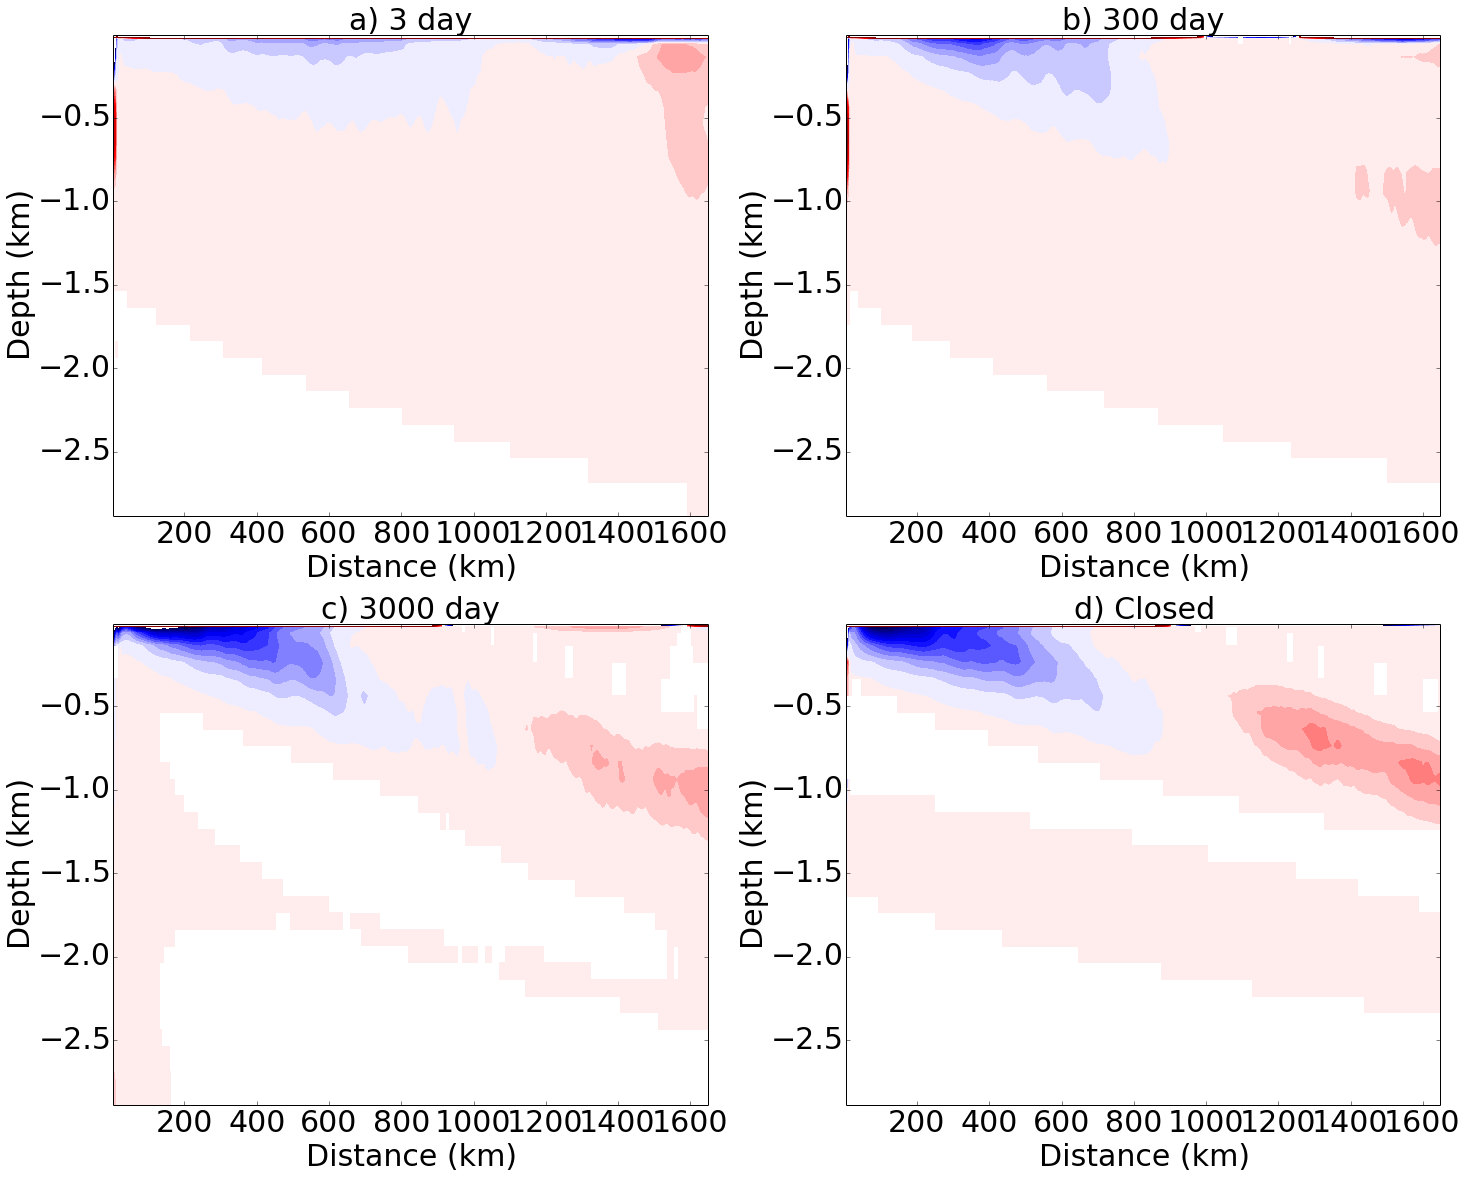

In [118]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:]
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:].mean(axis=0)
    TTav = filetav.variables['THETA'][:].mean(axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav = hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    Tz[np.round(Tz,4) == 0]=np.nan
    Ty[np.round(Ty,4) == 0]=np.nan
    Zmatrix = - Zmatrix
    Tz = Tz #/Zmatrix
    Ty = Ty #/ 5000
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty
    WTMz = WTav.mean(axis=2)*Tz
    VTpy = np.gradient(VTp.mean(axis=2),5000)[1]
    WTpz = np.gradient(WTp.mean(axis=2))[0]/Zmatrix
    WTMZ = WTMz
    WTpZ = WTpz
    # Diabatic Eddy
    D = VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dz, Dy = np.gradient(D)
    Dy = (Dy/5000)
    # ROC
    Mean = (WTMZ+VTMy )
    Vstar = Tz*WTp.mean(axis=2) 
    ADed =(WTpZ + Vstar*Tz )
    ROC =  (Mean + ADed)
    rlvls = np.arange(-3,3,0.21)
    if Full == 'N':
        ax = fig.add_subplot(2, 2, i+1)
        p = ax.contourf(yr, Z/1000, Mean[:,0:-70]*10**5, rlvls, cmap=plt.cm.seismic)  # Use b2r colourmap
        #plt.plot(yr,(Psipred[0:-70]-SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1))*10**5,'--k',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(ROC[0:5,:],axis=0)[0:-70],15,1)*10**5,'k',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1)*10**5,'b',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(ADed[0:5,:],axis=0)[0:-70],15,1)*10**5,'--r',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(Mean[0:5,:],axis=0)[0:-70],15,1)*10**5,'g',linewidth=2)
        #plt.plot(y,Psipred*10**5,'r',linewidth=2)
        #plt.plot(y,Psipred*10**-9,'k',linewidth=1)
        #plt.ylim(-1.0,1.8)
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day',fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]),fontsize=30)
    ax.set_xlabel('Distance (km)',fontsize=30)
    ax.set_ylabel(r'Depth (km)',fontsize=30)
    ax.tick_params(labelsize=30)
#lgd=plt.legend([r'B+D',r'ROC','D'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

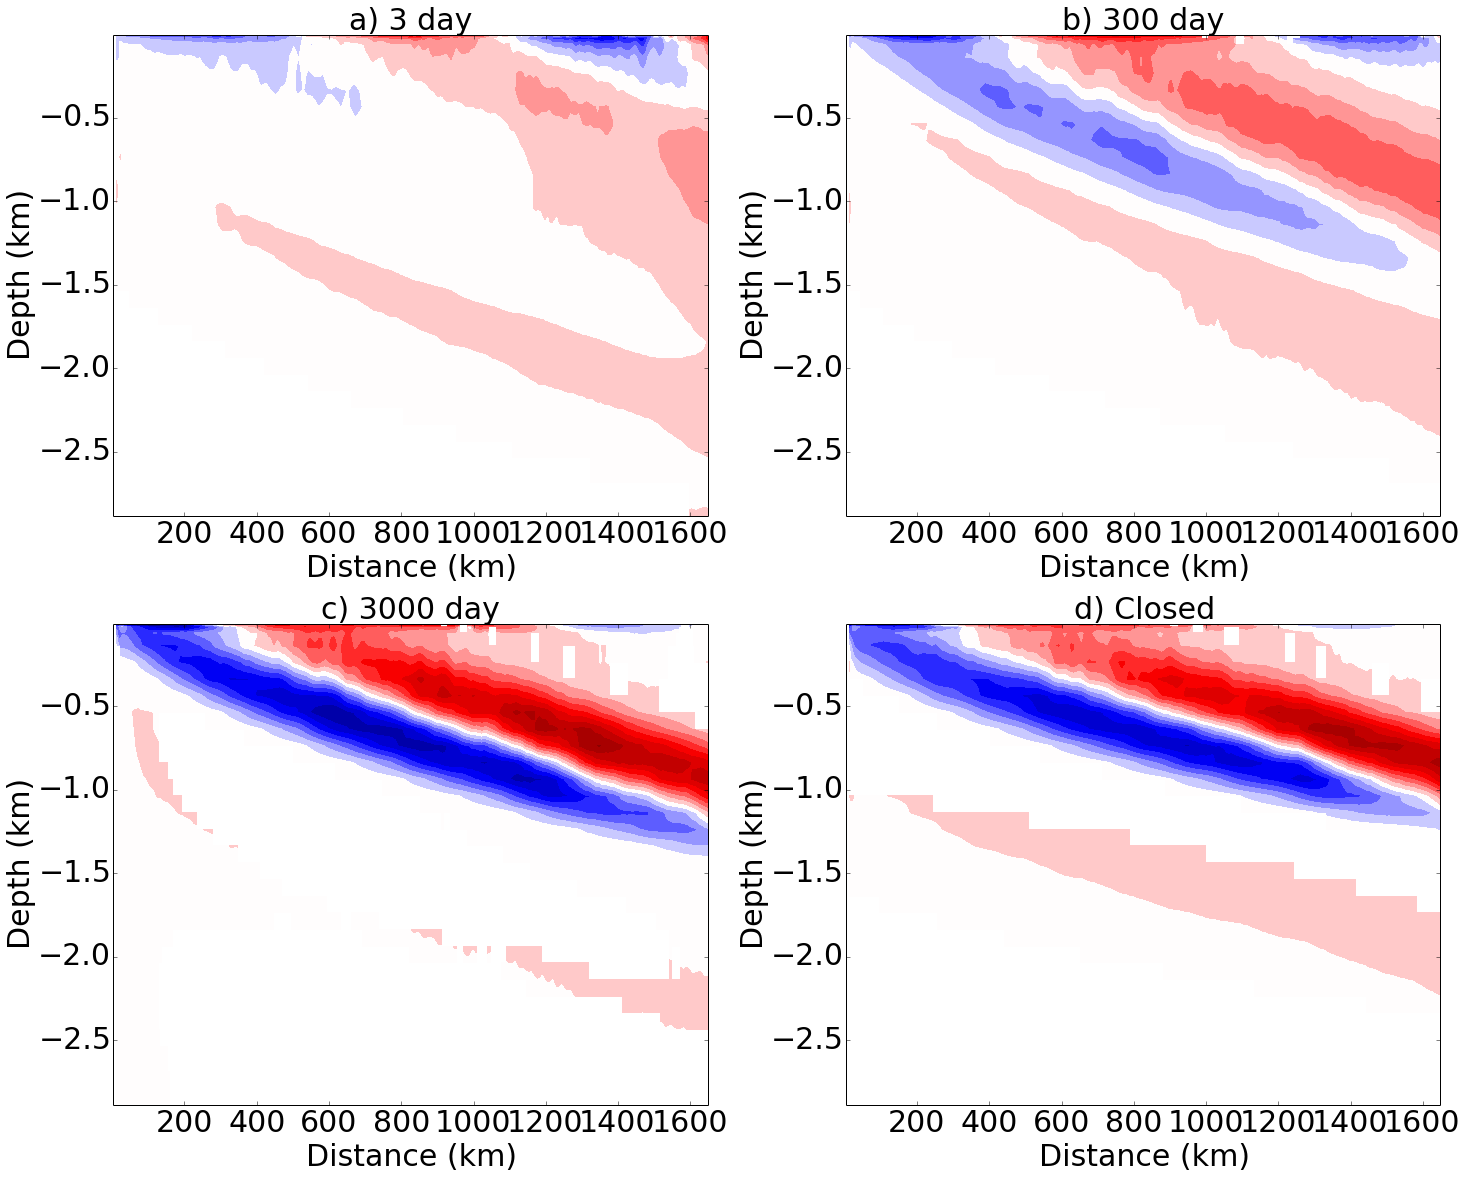

In [117]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:]
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:].mean(axis=0)
    TTav = filetav.variables['THETA'][:].mean(axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav = hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    Tz[np.round(Tz,4) == 0]=np.nan
    Ty[np.round(Ty,4) == 0]=np.nan
    Zmatrix = - Zmatrix
    Tz = Tz #/Zmatrix
    Ty = Ty #/ 5000
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty
    WTMz = WTav.mean(axis=2)*Tz
    VTpy = np.gradient(VTp.mean(axis=2),5000)[1]
    WTpz = np.gradient(WTp.mean(axis=2))[0]/Zmatrix
    WTMZ = WTMz
    WTpZ = WTpz
    # Diabatic Eddy
    D = VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dz, Dy = np.gradient(D)
    Dy = (Dy)/5000
    # ROC
    Mean = (WTMZ+VTMy )
    Vstar = Tz*WTp.mean(axis=2) 
    ADed =(WTpZ + Vstar*Tz )
    ROC =  (Mean + ADed)
    rlvls = np.arange(-2,2,0.2)/200
    if Full == 'N':
        ax = fig.add_subplot(2, 2, i+1)
        p = ax.contourf(yr, Z[:]/1000, Dy[:,0:-70]*10**5, rlvls, cmap=plt.cm.seismic)  # Use b2r colourmap
        #plt.plot(yr,(Psipred[0:-70]-SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1))*10**5,'--k',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(ROC[0:5,:],axis=0)[0:-70],15,1)*10**5,'k',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1)*10**5,'b',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(ADed[0:5,:],axis=0)[0:-70],15,1)*10**5,'--r',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(Mean[0:5,:],axis=0)[0:-70],15,1)*10**5,'g',linewidth=2)
        #plt.plot(y,Psipred*10**5,'r',linewidth=2)
        #plt.plot(y,Psipred*10**-9,'k',linewidth=1)
        #plt.ylim(-1.0,1.8)
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day',fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]),fontsize=30)
    ax.set_xlabel('Distance (km)',fontsize=30)
    ax.set_ylabel(r'Depth (km)',fontsize=30)
    ax.tick_params(labelsize=30)
#lgd=plt.legend([r'B+D',r'ROC','D'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

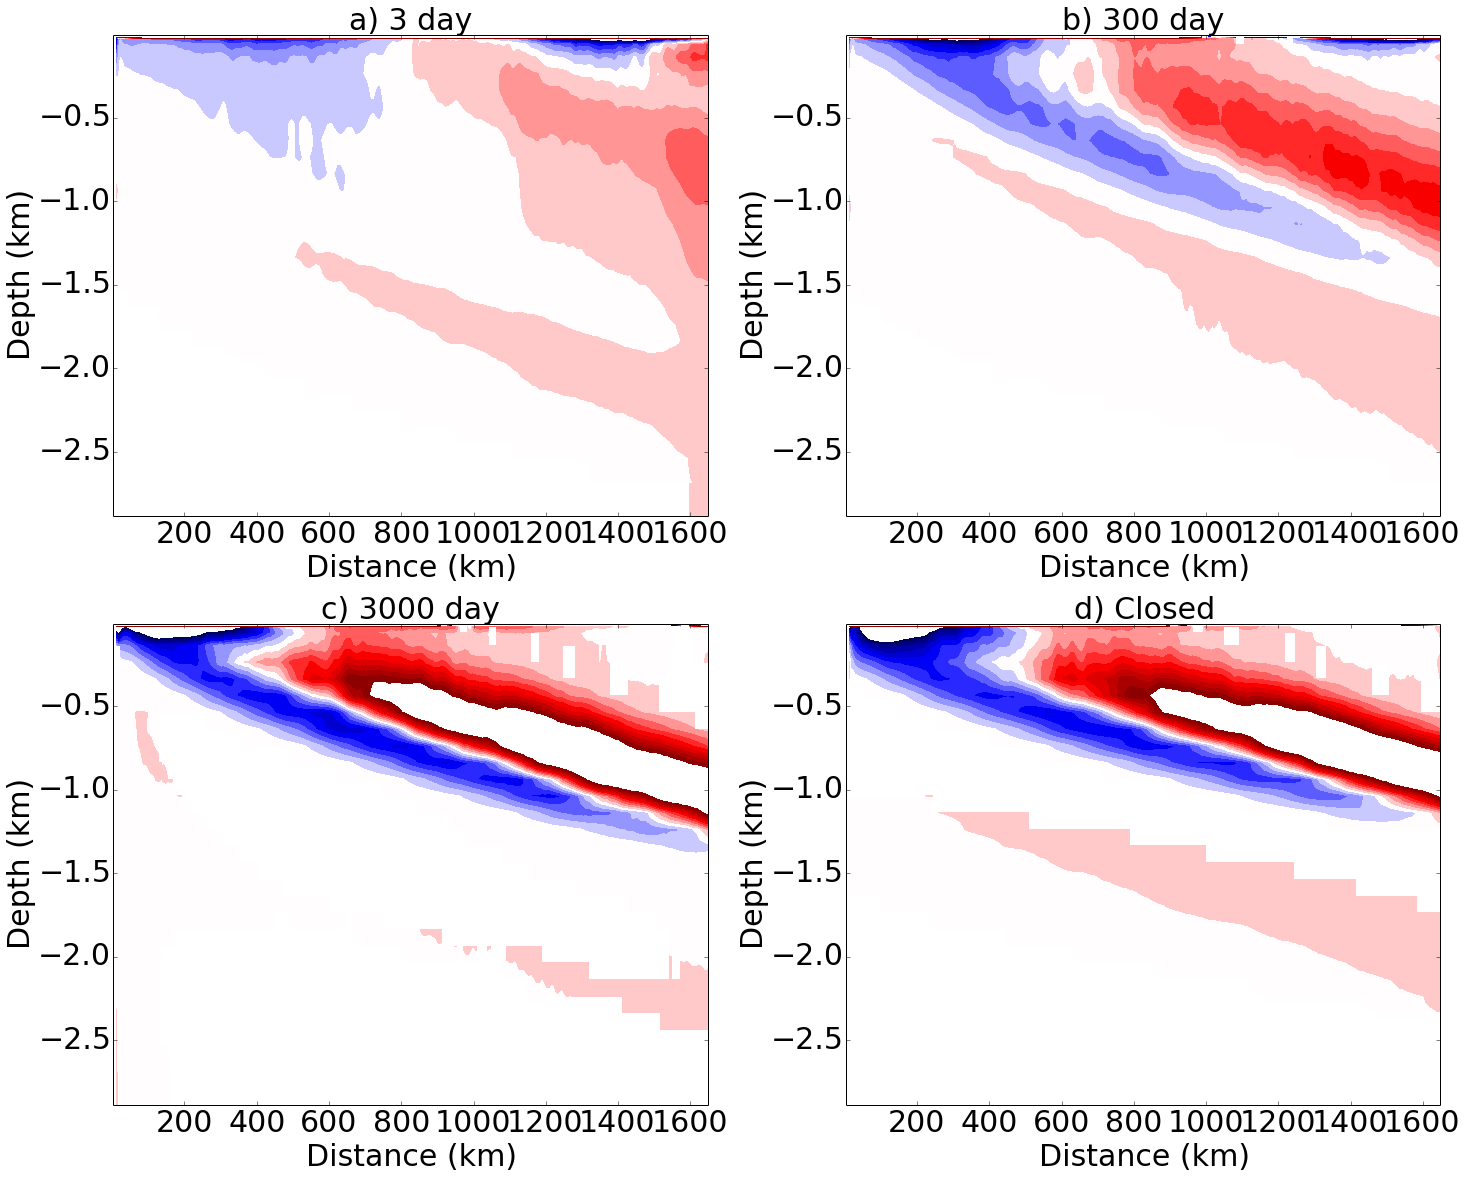

In [124]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:]
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:].mean(axis=0)
    TTav = filetav.variables['THETA'][:].mean(axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav = hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    Tz[np.round(Tz,4) == 0]=np.nan
    Ty[np.round(Ty,4) == 0]=np.nan
    Zmatrix = - Zmatrix
    Tz = Tz #/Zmatrix
    Ty = Ty #/ 5000
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty
    WTMz = WTav.mean(axis=2)*Tz
    VTpy = np.gradient(VTp.mean(axis=2),5000)[1]
    WTpz = np.gradient(WTp.mean(axis=2))[0]/Zmatrix
    WTMZ = WTMz
    WTpZ = WTpz
    # Diabatic Eddy
    D = VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dz, Dy = np.gradient(D)
    Dy = (Dy)/5000
    # ROC
    Mean = (WTMZ+VTMy )
    Vstar = Tz*WTp.mean(axis=2) 
    ADed =(WTpZ + Vstar*Tz )
    ROC =  (Mean + ADed)
    Res = ROC + Dy*200
    rlvls = np.arange(-2,2,0.2)
    if Full == 'N':
        ax = fig.add_subplot(2, 2, i+1)
        p = ax.contourf(yr, Z[:]/1000, Res[:,0:-70]*10**5, rlvls, cmap=plt.cm.seismic)  # Use b2r colourmap
        #plt.plot(yr,(Psipred[0:-70]-SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1))*10**5,'--k',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(ROC[0:5,:],axis=0)[0:-70],15,1)*10**5,'k',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(Dy[0:5,:],axis=0)[0:-70],15,1)*10**5,'b',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(ADed[0:5,:],axis=0)[0:-70],15,1)*10**5,'--r',linewidth=2)
        #plt.plot(yr,SG.savitzky_golay(np.nansum(Mean[0:5,:],axis=0)[0:-70],15,1)*10**5,'g',linewidth=2)
        #plt.plot(y,Psipred*10**5,'r',linewidth=2)
        #plt.plot(y,Psipred*10**-9,'k',linewidth=1)
        #plt.ylim(-1.0,1.8)
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day',fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]),fontsize=30)
    ax.set_xlabel('Distance (km)',fontsize=30)
    ax.set_ylabel(r'Depth (km)',fontsize=30)
    ax.tick_params(labelsize=30)
#lgd=plt.legend([r'B+D',r'ROC','D'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide


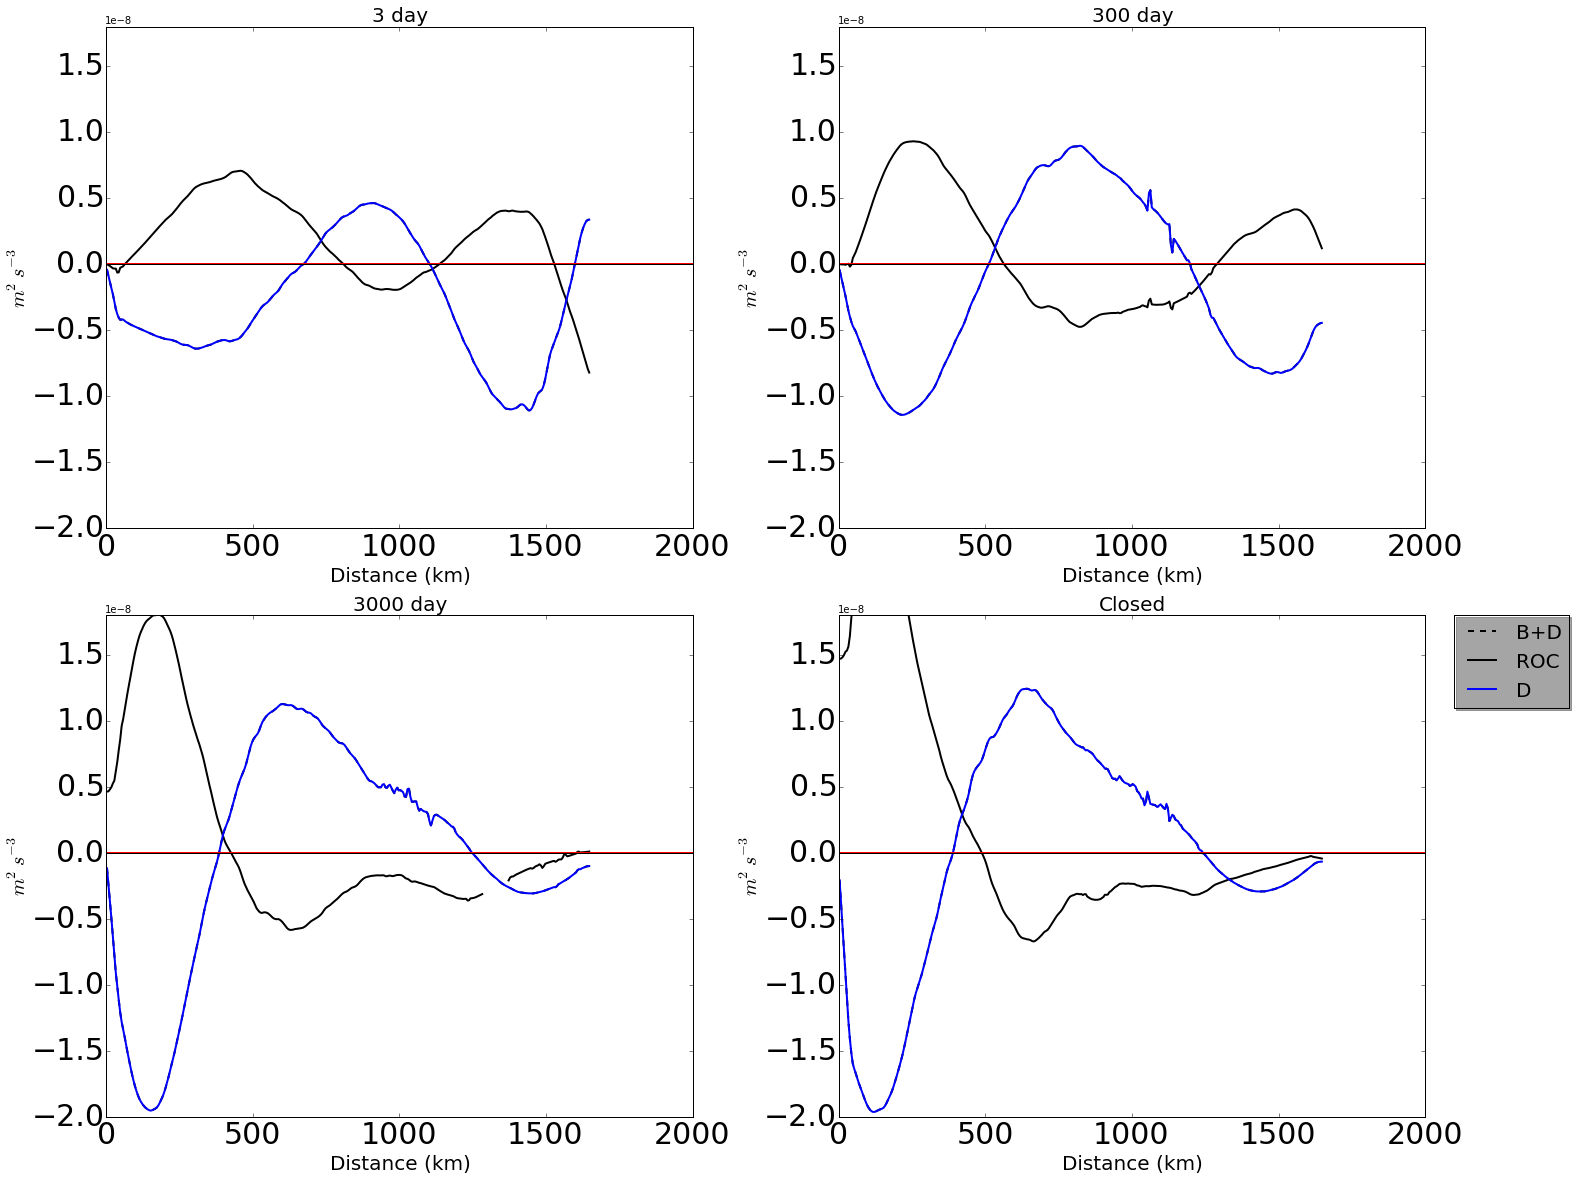

In [33]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:]
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:]
    VTav = np.mean(VTav,axis=0)
    TTav = filetav.variables['THETA'][:]
    TTav = np.mean(TTav,axis=0)#-4.0
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav = hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty/5000
    WTMz = WTav.mean(axis=2)*Tz
    VTpz, VTpy = np.gradient(VTp.mean(axis=2),5000)
    WTpz, WTpy = np.gradient(WTp.mean(axis=2))
    WTMZ = -WTMz/Zmatrix
    WTpZ = -WTpz/Zmatrix
    # Load Variables 
    fileVTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTbar.nc','r')
    VTb = fileVTprime.variables['VT'][:]
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTbar.nc','r')
    WTb = fileWTprime.variables['WT'][:]
    Wbz,Wby = np.gradient(WTb.mean(axis=2))
    Vbz,Vby = np.gradient(VTb.mean(axis=2))
    Vby = Vby/5000
    Wbz = Wbz/Zmatrix
    B = ((WTpZ+WTMZ+VTMy)*G*alpha)*Zmatrix
    D = VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dz, Dy = np.gradient(D)
    Dy = Dy/5000
    Vstar = np.gradient(WTp.mean(axis=2)/(Ty))[0]/Zmatrix
    Vstarz = np.gradient(Vstar,5000)[1]
    Bw = ((Dy*G*alpha))*Zmatrix
    # Psi_iso(y,z)
    fname = path+'/'+str(tau[Runs[i]])+'daynokpp/PSI.nc'
    file2read = netCDF4.Dataset(fname,'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    psi = hb.ROC(lvrho)
    Rho = np.genfromtxt(path+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter = ',')
    nolayers = len(psi[:,1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust 
    PY, zexp, texp = hb.ROCY(lvrho,Z,Rho,TTav.mean(axis=2))
    PY = np.apply_along_axis(hb.maxmag,0,PY[0:25,:])/5000   
    ROC = ((WTpZ+Vstarz+WTMZ+VTMy)*G*alpha)*Zmatrix
    PYz = np.gradient(PY,np.diff(zexp)[0])[0]
    if Full == 'N':
        ax = fig.add_subplot(2, 2, i+1)
        plt.plot(Yc[0:-70]/1000,(Psipred[0:-70]-SG.savitzky_golay(np.nansum(Bw[0:4,:],axis=0)[0:-70],15,1)),'--k',linewidth=2)
        plt.plot(Yc[0:-70]/1000,-SG.savitzky_golay(np.sum(ROC[0:4,:],axis=0)[0:-70],15,1),'k',linewidth=2)
        plt.plot(Yc[0:-70]/1000,-SG.savitzky_golay(np.nansum(Bw[0:4,:],axis=0)[0:-70],15,1),'b',linewidth=2)
        plt.plot(Yc/1000,Psipred,'r',linewidth=2)
        plt.plot(Yc/1000,Psipred*10**-9,'k',linewidth=1)
        plt.ylim(-2*10**-8,1.8*10**-8)
        ax.set_title(str(tau[Runs[i]])+' day',fontsize=20)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(tau[Runs[i]]),fontsize=20)
    ax.set_xlabel('Distance (km)',fontsize=20)
    ax.set_ylabel('$m^2s^{-3}$',fontsize=20)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'B+D',r'ROC','D'], shadow=True,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

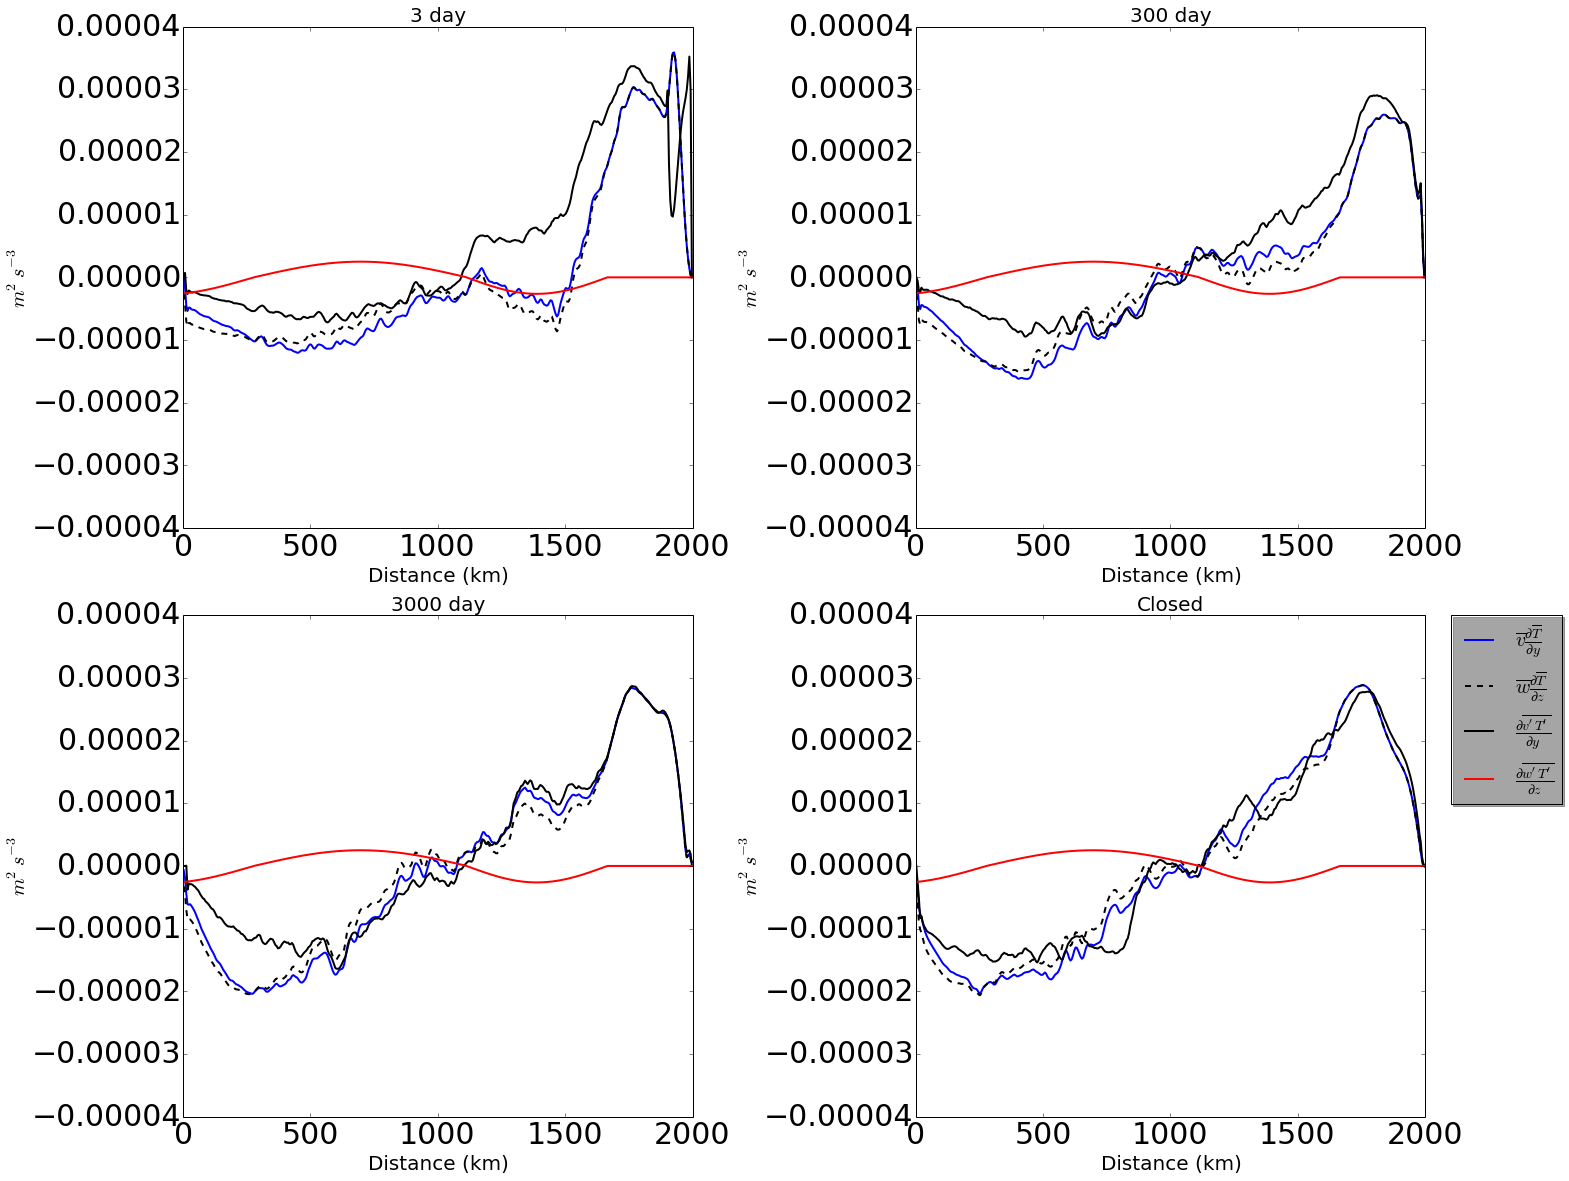

In [147]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp=fileVTprime.variables['VT'][:]
    fileWTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp= fileWTprime.variables['WT'][:]
    #fileUTprime= netCDF4.Dataset(gridfilepath+'/UTprimebar.nc','r')
    #UTp= fileUTprime.variables['UT'][:]
    filetav= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav= filetav.variables['VVEL'][:]
    VTav=np.mean(VTav,axis=0)
    #UTav= filetav.variables['UVEL'][:]
    #UTav=np.squeeze(UTav)
    TTav = filetav.variables['THETA'][:]
    TTav = np.mean(TTav,axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    else:
        TTav = TTav-4.0
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad=((0,0),(0,1),(0,0),(0,0))
    WTav=np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav=hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    Tz = Tz/Zmatrix
    Tz[np.round(Tz,4) == 0]=0
    Ty = Ty/5000
    Ty[np.round(Ty,4) == 0]=0
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty
    WTMz = WTav.mean(axis=2)*Tz
    VTpz, VTpy = np.gradient(VTp.mean(axis=2),5000)
    #UTpz, UTpy, UTpx = np.gradient(UTp,5000)
    WTpz,WTpy = np.gradient(WTp.mean(axis=2))
    WTMZ=WTMz
    WTpZ=WTpz/Zmatrix
    B=((WTpZ+WTMZ+VTMy))*Zmatrix
    D= VTpy
    if Full=='N':
        ax = fig.add_subplot(2, 2, i+1)
        #p1 = plt.plot(Yc/1000,(Zmatrix*VTMy).sum(axis=0),'r',linewidth=2)
        #p1 = plt.plot(Yc/1000,(Zmatrix*WTMZ).sum(axis=0),'m',linewidth=2)
        p1 = plt.plot(Yc/1000,(Zmatrix*VTpy)[:].sum(axis=0),'b',linewidth=2)
        #p1 = plt.plot(Yc/1000,(Zmatrix*WTpZ).sum(axis=0),'--c',linewidth=2)
        p1 = plt.plot(Yc/1000,(Zmatrix*VTpy)[:].sum(axis=0)+Psipred,'--k',linewidth=2)
        p1 = plt.plot(Yc/1000,(B)[:].sum(axis=0),'k',linewidth=2)        
        #p1 = plot(Yc[0:-50]/1000,SG.savitzky_golay(nansum(B,axis=0)[0:-50],15,1),'k',linewidth=2)
        p1 = plt.plot(Yc/1000,Psipred,'r',linewidth=2)
        plt.ylim(-4*10**-5,4*10**-5)
        ax.set_title(str(tau[Runs[i]])+' day',fontsize=20)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]),fontsize=20)
    ax.set_xlabel('Distance (km)',fontsize=20)
    ax.set_ylabel('$m^2s^{-3}$',fontsize=20)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'$\overline{v}\frac{\partial \overline{T}}{\partial y}$',r'$ \overline{w}\frac{\partial \overline{T}}{\partial z}$',r'$ \frac{\partial \overline{v^\prime T ^\prime }}{\partial y}$',r'$  \frac{\partial \overline{w ^\prime T ^\prime}}{\partial z}$'], shadow=True,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

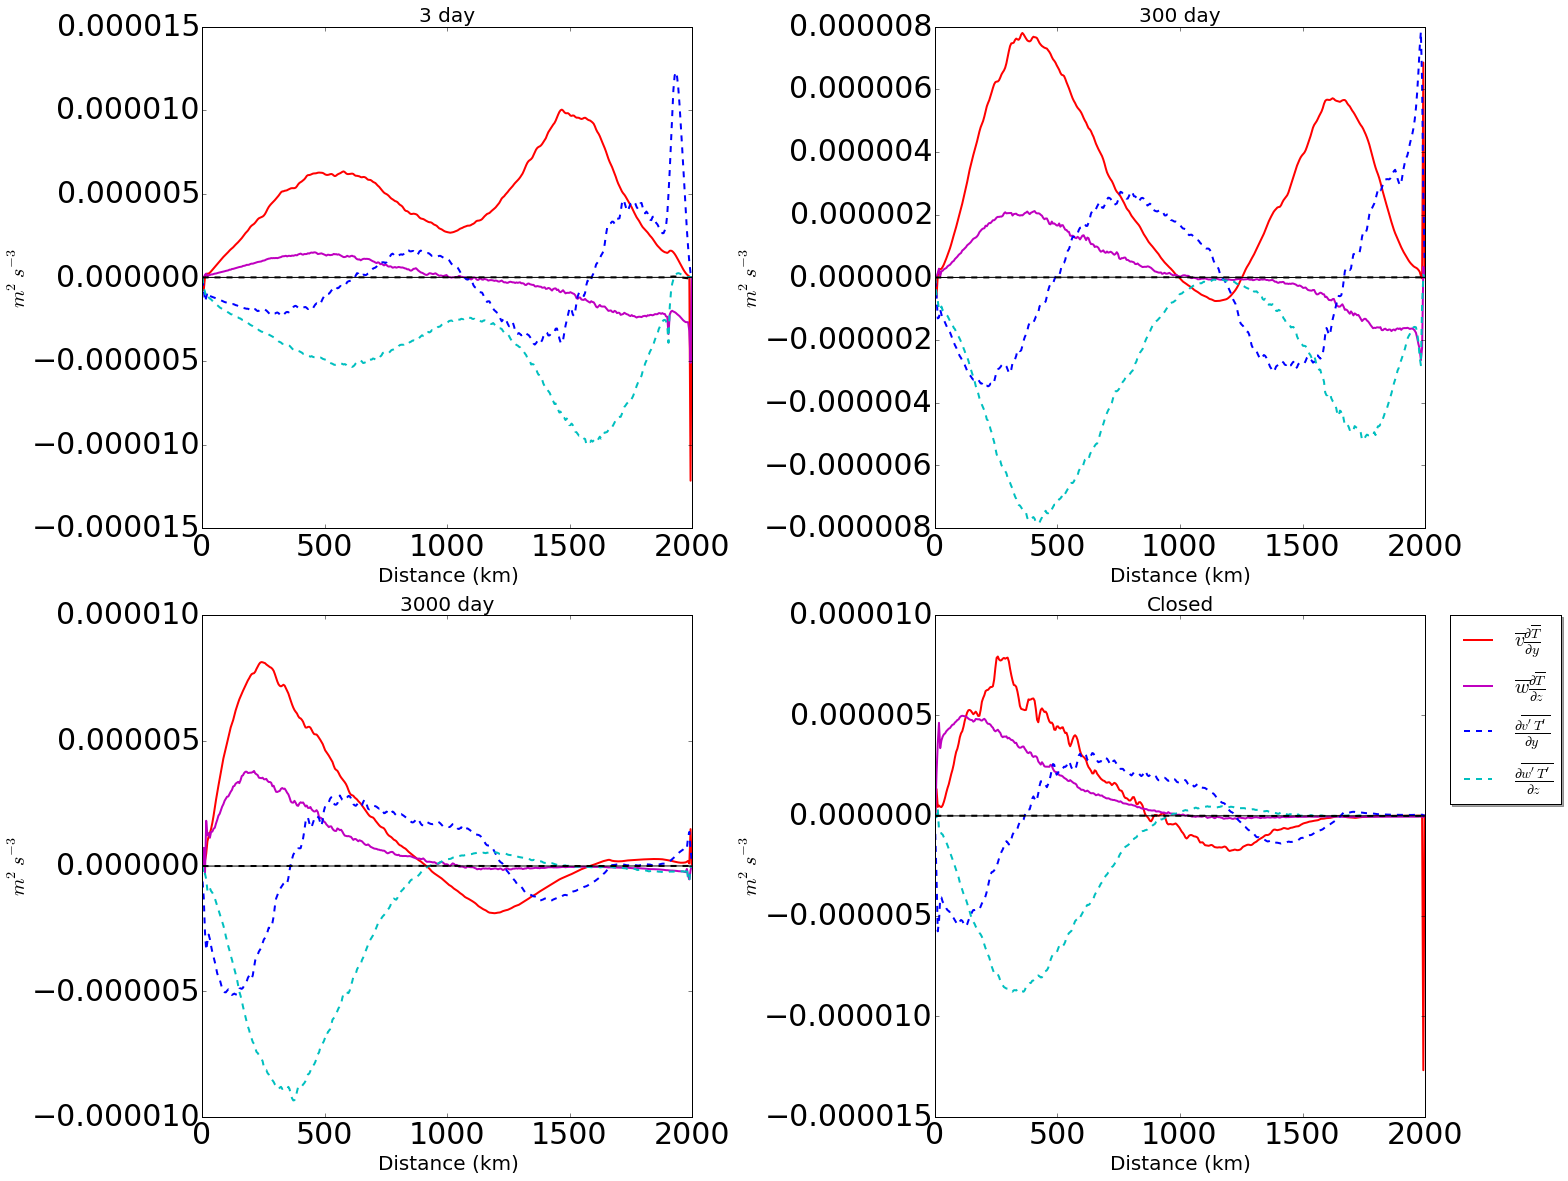

In [9]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp=fileVTprime.variables['VT'][:]
    fileWTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp= fileWTprime.variables['WT'][:]
    filetav= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav= filetav.variables['VVEL'][:]
    VTav=np.mean(VTav,axis=0)
    TTav = filetav.variables['THETA'][:]
    TTav = np.mean(TTav,axis=0)-4.0
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad=((0,0),(0,1),(0,0),(0,0))
    WTav=np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav=hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = gradient(TTav.mean(axis=2))
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty/5000
    WTMz = WTav.mean(axis=2)*Tz
    VTpz, VTpy = np.gradient(VTp.mean(axis=2),5000)
    WTpz,WTpy = gradient(WTp.mean(axis=2))
    WTMZ=-WTMz/Zmatrix
    WTpZ=-WTpz/Zmatrix
    B=-((WTpZ+VTpy+WTMZ+VTMy)*G*alpha)*Zmatrix
    if Full=='N':
        ax = fig.add_subplot(2, 2, i+1)
        p1 = plot(Yc/1000,(Zmatrix*VTMy)[0:3].sum(axis=0),'r',linewidth=2)
        p1 = plot(Yc/1000,(Zmatrix*WTMZ)[0:3].sum(axis=0),'m',linewidth=2)
        p1 = plot(Yc/1000,(Zmatrix*VTpy)[0:3].sum(axis=0),'--b',linewidth=2)
        p1 = plot(Yc/1000,(Zmatrix*WTpZ)[0:3].sum(axis=0),'--c',linewidth=2)
        p1 = plot(Yc/1000,(B).sum(axis=0),'--k',linewidth=2)
        p1 = plot(Yc/1000,Psipred,'k',linewidth=1)
        #ylim(-4*10**-5,4*10**-5)
        ax.set_title(str(tau[Runs[i]])+' day',fontsize=20)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]),fontsize=20)
    ax.set_xlabel('Distance (km)',fontsize=20)
    ax.set_ylabel('$m^2s^{-3}$',fontsize=20)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'$\overline{v}\frac{\partial \overline{T}}{\partial y}$',r'$ \overline{w}\frac{\partial \overline{T}}{\partial z}$',r'$ \frac{\partial \overline{v^\prime T ^\prime }}{\partial y}$',r'$  \frac{\partial \overline{w ^\prime T ^\prime}}{\partial z}$'], shadow=True,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

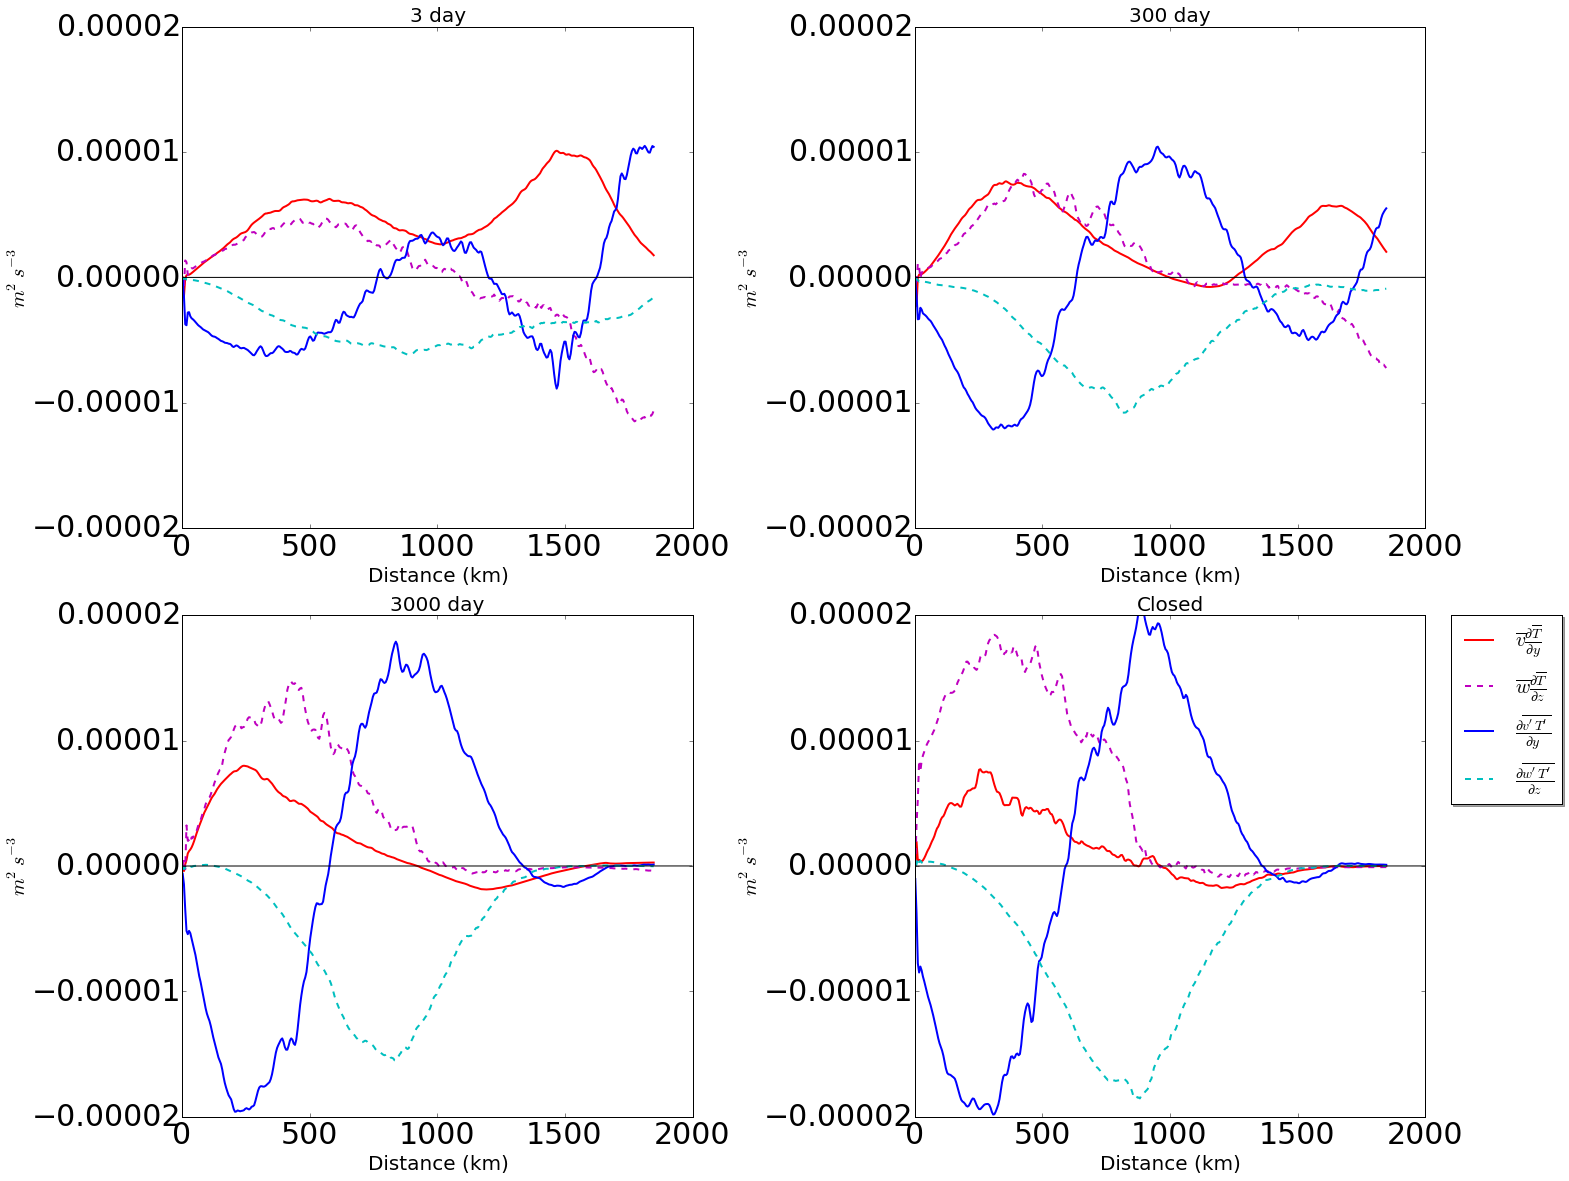

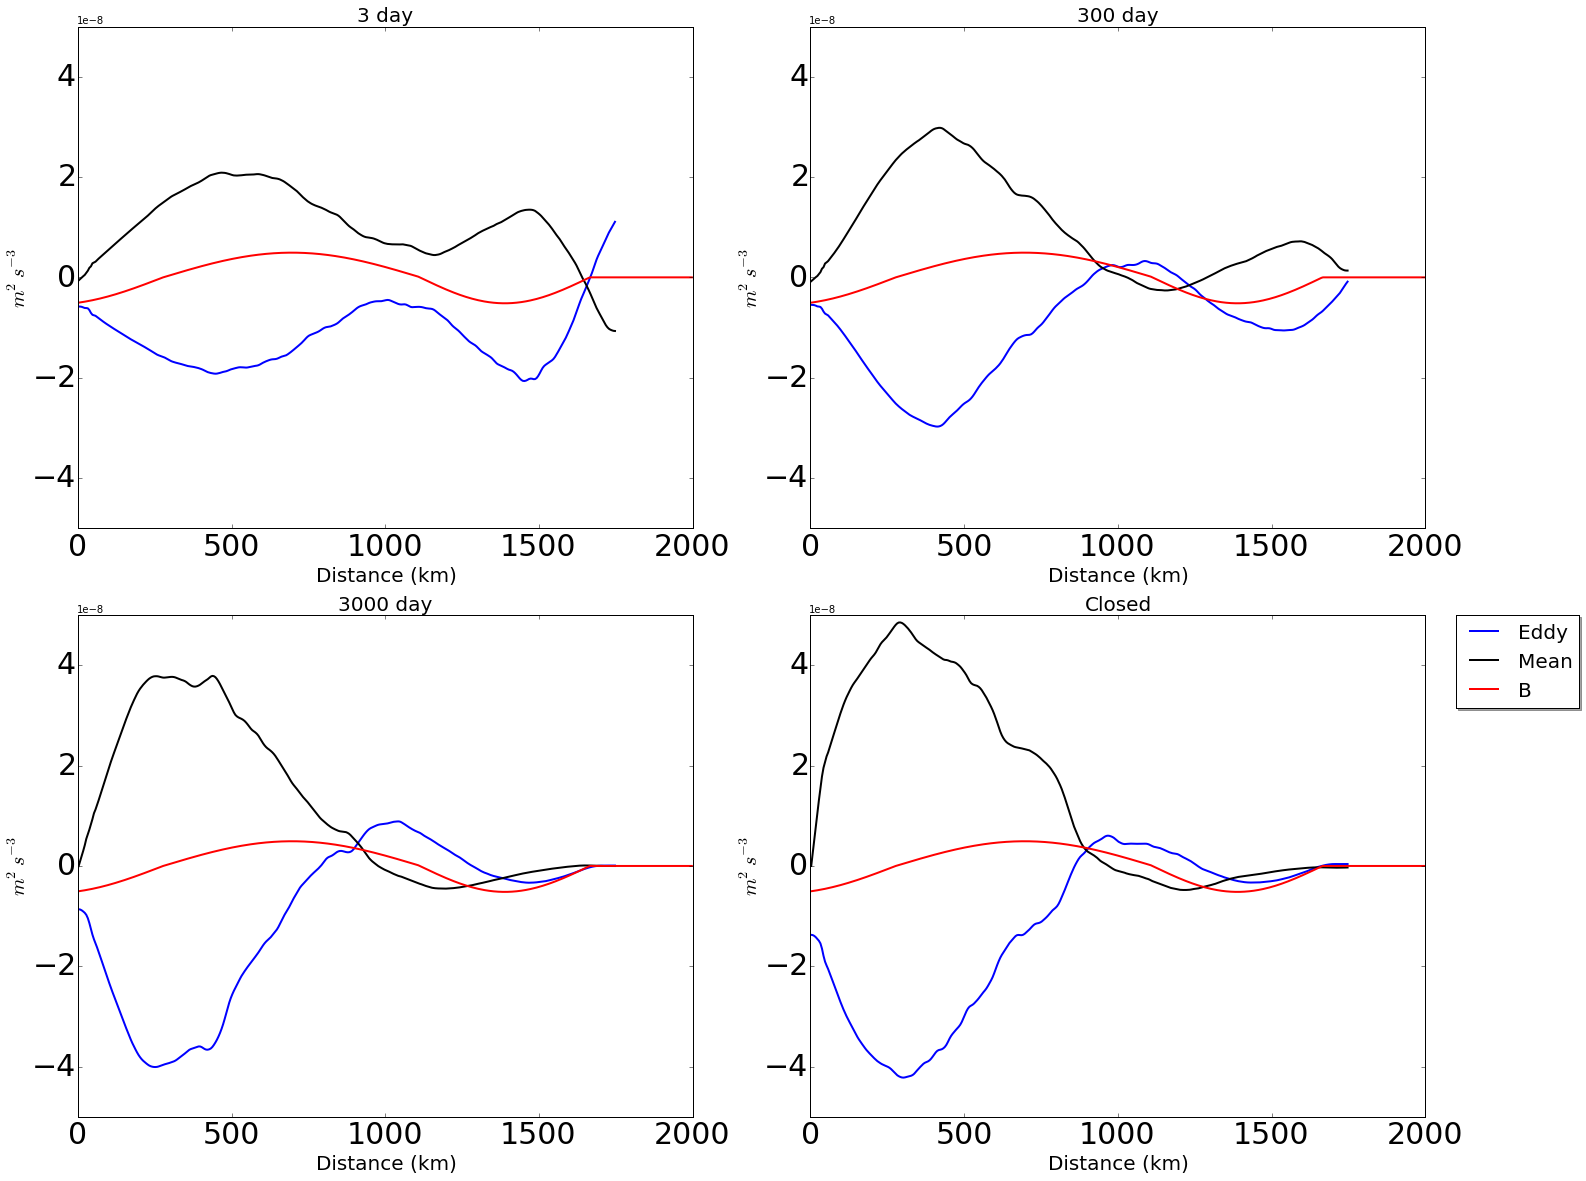

In [10]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp=fileVTprime.variables['VT'][:]
    fileWTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp= fileWTprime.variables['WT'][:]
    #fileUTprime= netCDF4.Dataset(gridfilepath+'/UTprimebar.nc','r')
    #UTp= fileUTprime.variables['UT'][:]
    filetav= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav= filetav.variables['VVEL'][:]
    VTav=np.mean(VTav,axis=0)
    #UTav= filetav.variables['UVEL'][:]
    #UTav=np.squeeze(UTav)
    TTav = filetav.variables['THETA'][:]
    TTav = np.mean(TTav,axis=0)-4.0
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad=((0,0),(0,1),(0,0),(0,0))
    WTav=np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav=hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = gradient(TTav.mean(axis=2))
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty/5000
    WTMz = WTav.mean(axis=2)*Tz
    VTpz, VTpy = np.gradient(VTp.mean(axis=2),5000)
    #UTpz, UTpy, UTpx = np.gradient(UTp,5000)
    WTpz,WTpy = gradient(WTp.mean(axis=2))
    WTMZ=-WTMz/Zmatrix
    WTpZ=-WTpz/Zmatrix
    B=-((WTpZ+VTpy+WTMZ+VTMy)*G*alpha)*Zmatrix
    if Full=='N':
        ax = fig.add_subplot(2, 2, i+1)
        p1 = plot(Yc[0:-30]/1000,(Zmatrix*VTMy)[0:7,0:-30].sum(axis=0),'r',linewidth=2)
        p1 = plot(Yc[0:-30]/1000,(Zmatrix*WTMZ)[0:7,0:-30].sum(axis=0),'--m',linewidth=2)
        p1 = plot(Yc[0:-30]/1000,(Zmatrix*VTpy)[0:7,0:-30].sum(axis=0),'b',linewidth=2)
        p1 = plot(Yc[0:-30]/1000,(Zmatrix*WTpZ)[0:7,0:-30].sum(axis=0),'--c',linewidth=2)
        #p1 = plot(Yc[0:-50]/1000,SG.savitzky_golay(nansum(B,axis=0)[0:-50],15,1),'k',linewidth=2)
        p1 = plot(Yc/1000,Psipred,'k',linewidth=1)
        ylim(-2*10**-5,2*10**-5)
        ax.set_title(str(tau[Runs[i]])+' day',fontsize=20)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]),fontsize=20)
    ax.set_xlabel('Distance (km)',fontsize=20)
    ax.set_ylabel('$m^2s^{-3}$',fontsize=20)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'$\overline{v}\frac{\partial \overline{T}}{\partial y}$',r'$ \overline{w}\frac{\partial \overline{T}}{\partial z}$',r'$ \frac{\partial \overline{v^\prime T ^\prime }}{\partial y}$',r'$  \frac{\partial \overline{w ^\prime T ^\prime}}{\partial z}$'], shadow=True,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp=fileVTprime.variables['VT'][:]
    fileWTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp= fileWTprime.variables['WT'][:]
    #fileUTprime= netCDF4.Dataset(gridfilepath+'/UTprimebar.nc','r')
    #UTp= fileUTprime.variables['UT'][:]
    filetav= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav= filetav.variables['VVEL'][:]
    VTav=np.mean(VTav,axis=0)
    #UTav= filetav.variables['UVEL'][:]
    #UTav=np.squeeze(UTav)
    TTav = filetav.variables['THETA'][:]
    TTav = np.mean(TTav,axis=0)-4.0
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad=((0,0),(0,1),(0,0),(0,0))
    WTav=np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav=hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = gradient(TTav.mean(axis=2))
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty/5000
    WTMz = WTav.mean(axis=2)*Tz
    VTpz, VTpy = np.gradient(VTp.mean(axis=2),5000)
    #UTpz, UTpy, UTpx = np.gradient(UTp,5000)
    WTpz,WTpy = gradient(WTp.mean(axis=2))
    WTMZ=-WTMz/Zmatrix
    WTpZ=-WTpz/Zmatrix
    B=-((WTpZ+VTpy)*G*alpha)*Zmatrix
    Bw=-((WTMZ+VTMy)*G*alpha)*Zmatrix
    #B[abs(B)<3*10**-10]=np.nan
    if Full=='N':
        ax = fig.add_subplot(2, 2, i+1)
        plot(Yc[0:-50]/1000,SG.savitzky_golay(nansum(B[0:7,:],axis=0)[0:-50],15,1),'b',linewidth=2)
        plot(Yc[0:-50]/1000,SG.savitzky_golay(nansum(Bw[0:7,:],axis=0)[0:-50],15,1),'k',linewidth=2)
        plot(Yc/1000,Psipred,'r',linewidth=2)
        ylim(-5*10**-8,5.0*10**-8)
        ax.set_title(str(tau[Runs[i]])+' day',fontsize=20)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]),fontsize=20)
    ax.set_xlabel('Distance (km)',fontsize=20)
    ax.set_ylabel('$m^2s^{-3}$',fontsize=20)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'Eddy',r'Mean','B'], shadow=True,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

-c:43: RuntimeWarning: divide by zero encountered in divide
-c:43: RuntimeWarning: invalid value encountered in divide
/nerc/packages/anaconda/v2014.10.29/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:1000: RuntimeWarning: invalid value encountered in subtract
  out[slice1] = (y[slice2] - y[slice3])/2.0
/nerc/packages/anaconda/v2014.10.29/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:1012: RuntimeWarning: invalid value encountered in subtract
  out[slice1] = (y[slice2] - y[slice3])


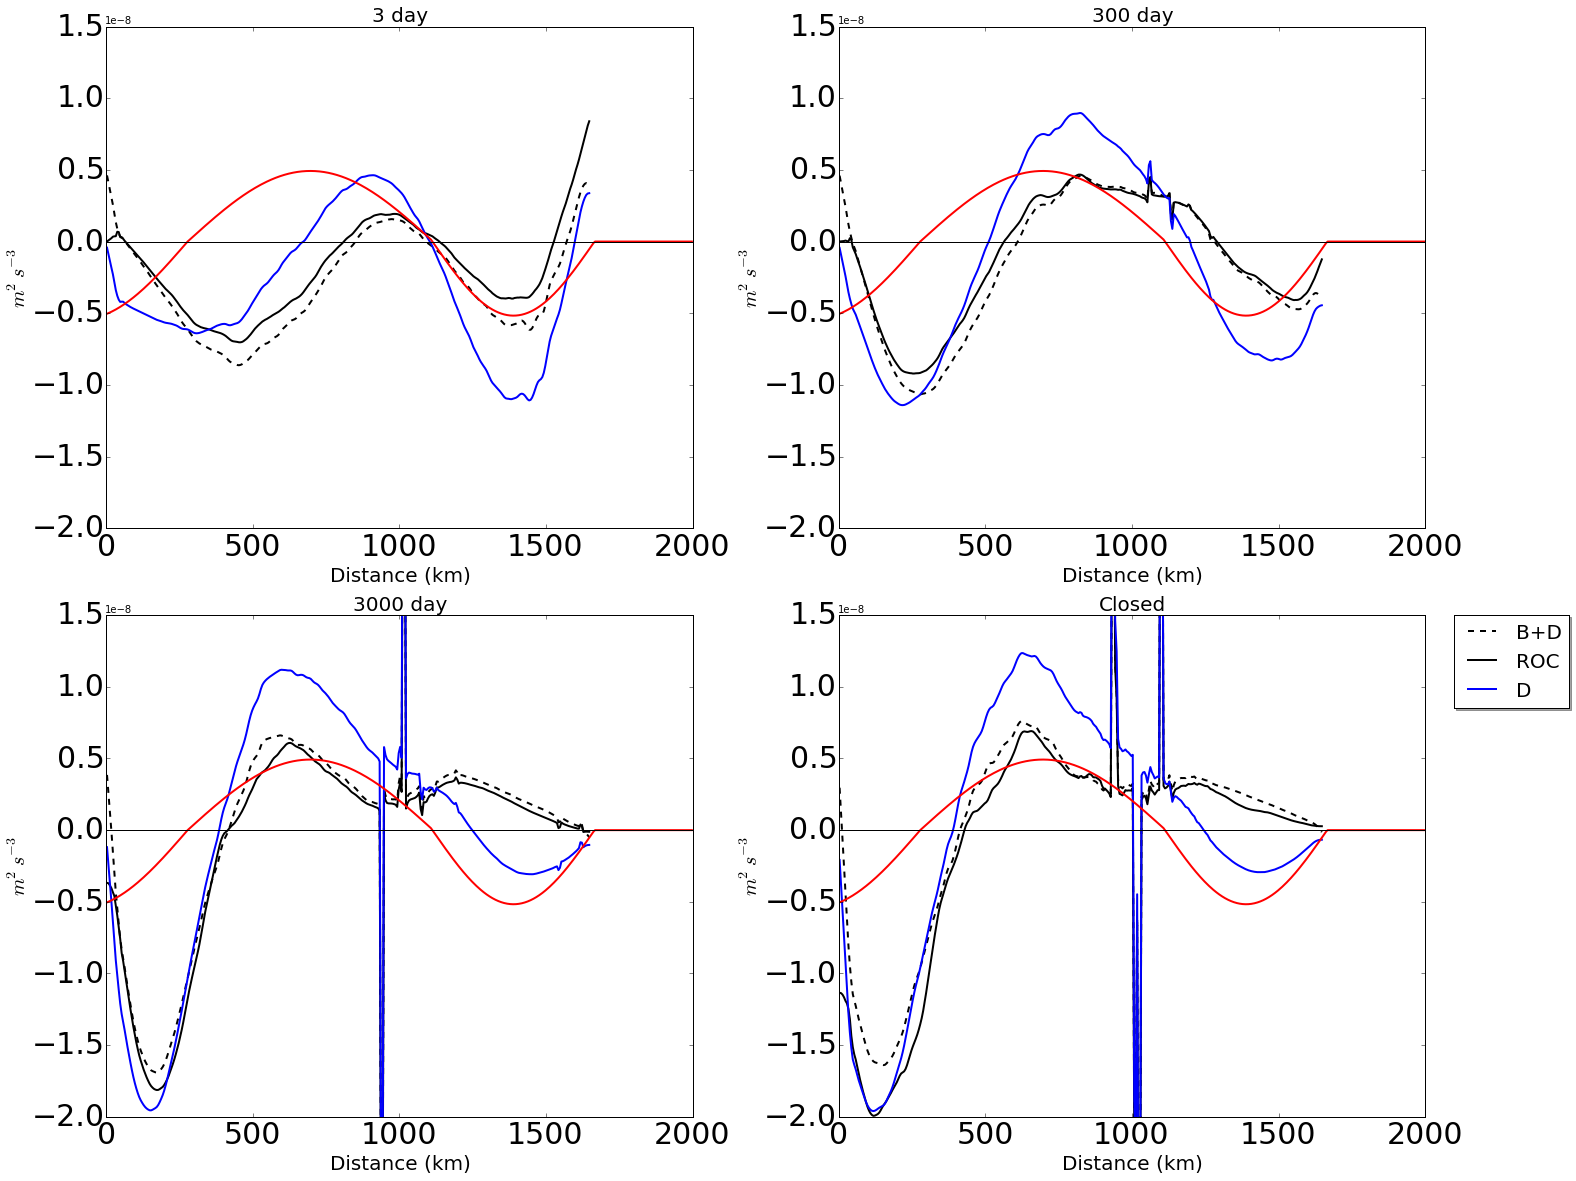

In [11]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp=fileVTprime.variables['VT'][:]
    fileWTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp= fileWTprime.variables['WT'][:]
    #fileUTprime= netCDF4.Dataset(gridfilepath+'/UTprimebar.nc','r')
    #UTp= fileUTprime.variables['UT'][:]
    filetav= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav= filetav.variables['VVEL'][:]
    VTav=np.mean(VTav,axis=0)
    #UTav= filetav.variables['UVEL'][:]
    #UTav=np.squeeze(UTav)
    TTav = filetav.variables['THETA'][:]
    TTav = np.mean(TTav,axis=0)#-4.0
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad=((0,0),(0,1),(0,0),(0,0))
    WTav=np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav=hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = gradient(TTav.mean(axis=2))
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty/5000
    WTMz = WTav.mean(axis=2)*Tz
    VTpz, VTpy = np.gradient(VTp.mean(axis=2),5000)
    #UTpz, UTpy, UTpx = np.gradient(UTp,5000)
    WTpz,WTpy = gradient(WTp.mean(axis=2))
    WTMZ=-WTMz/Zmatrix
    WTpZ=-WTpz/Zmatrix
    # Load Variables 
    fileVTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTbar.nc','r')
    VTb=fileVTprime.variables['VT'][:]
    fileWTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTbar.nc','r')
    WTb= fileWTprime.variables['WT'][:]
    Wbz,Wby = gradient(WTb.mean(axis=2))
    Vbz,Vby = gradient(VTb.mean(axis=2))
    Vby=Vby/5000
    Wbz=Wbz/Zmatrix
    B=((WTpZ+WTMZ+VTMy)*G*alpha)*Zmatrix
    D= VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dz,Dy = gradient(D)
    Dy=Dy/5000
    Bw=((Dy*G*alpha))*Zmatrix
    # Psi_iso(y,z)
    fname=path+'/'+str(tau[Runs[i]])+'daynokpp/PSI.nc'
    file2read = netCDF4.Dataset(fname,'r')
    lvrho=file2read.variables["LaVH1TH"][:]
    psi=hb.ROC(lvrho)
    Rho = np.genfromtxt(path+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter = ',')
    nolayers=len(psi[:,1])
    Rho=Rho[0:nolayers]#The layers package bins a layer so adjust \
    PY,zexp,texp=hb.ROCY(lvrho,Z,Rho,TTav.mean(axis=2))
    PY=np.apply_along_axis(hb.maxmag,0,PY[0:25,:])/5000   
    ROC=((WTpZ+VTpy+WTMZ+VTMy)*G*alpha)*Zmatrix-Bw
    PYz=np.gradient(PY,np.diff(zexp)[0])[0]
    #ROC=PYz*np.gradient(texp,5000)[1]
    if Full=='N':
        ax = fig.add_subplot(2, 2, i+1)
        plot(Yc[0:-70]/1000,-(Psipred[0:-70]+SG.savitzky_golay(nansum(Bw[0:4,:],axis=0)[0:-70],15,1)),'--k',linewidth=2)
        #plot(Yc[10:-10]/1000,SG.savitzky_golay(alpha*-G*(PY*np.mean(Ty[4:7,:],axis=0))[10:-10],11,1),'k',linewidth=2)
        plot(Yc[0:-70]/1000,SG.savitzky_golay(np.sum(ROC[0:4,:],axis=0)[0:-70],15,1),'k',linewidth=2)
        #plot(Yc[0:-70]/1000,SG.savitzky_golay(np.sum(ROC[:,:],axis=0)[0:-70],15,1),'k',linewidth=2)
        plot(Yc[0:-70]/1000,-SG.savitzky_golay(nansum(Bw[0:4,:],axis=0)[0:-70],15,1),'b',linewidth=2)
        plot(Yc/1000,Psipred,'r',linewidth=2)
        plot(Yc/1000,Psipred*10**-9,'k',linewidth=1)
        ylim(-2*10**-8,1.5*10**-8)
        ax.set_title(str(tau[Runs[i]])+' day',fontsize=20)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]),fontsize=20)
    ax.set_xlabel('Distance (km)',fontsize=20)
    ax.set_ylabel('$m^2s^{-3}$',fontsize=20)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'B+D',r'ROC','D'], shadow=True,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

-c:38: RuntimeWarning: divide by zero encountered in divide
-c:38: RuntimeWarning: invalid value encountered in divide


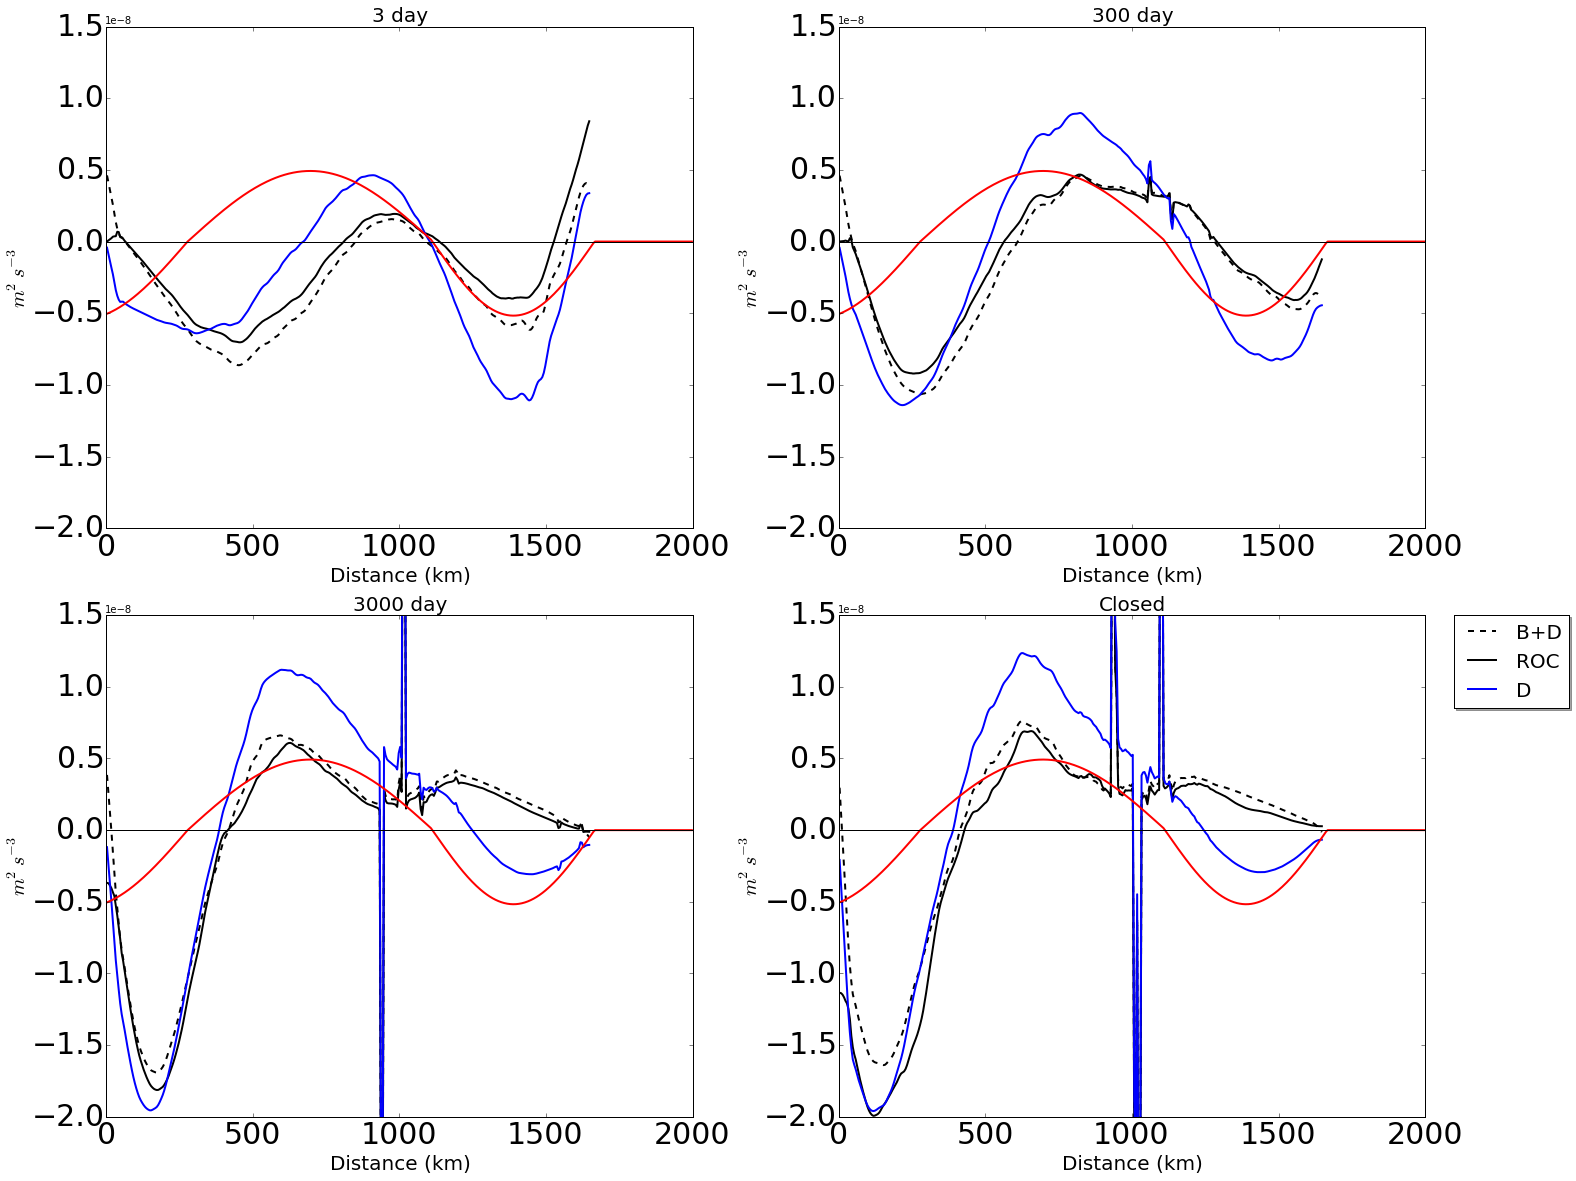

In [12]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp=fileVTprime.variables['VT'][:]
    fileWTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp= fileWTprime.variables['WT'][:]
    filetav= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav= filetav.variables['VVEL'][:]
    VTav=np.mean(VTav,axis=0)
    TTav = filetav.variables['THETA'][:]
    TTav = np.mean(TTav,axis=0)#-4.0
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad=((0,0),(0,1),(0,0),(0,0))
    WTav=np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav=hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = gradient(TTav.mean(axis=2))
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty/5000
    WTMz = WTav.mean(axis=2)*Tz
    VTpz, VTpy = np.gradient(VTp.mean(axis=2),5000)
    WTpz,WTpy = gradient(WTp.mean(axis=2))
    WTMZ=-WTMz/Zmatrix
    WTpZ=-WTpz/Zmatrix
    # Load Variables 
    fileVTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTbar.nc','r')
    VTb=fileVTprime.variables['VT'][:]
    fileWTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTbar.nc','r')
    WTb= fileWTprime.variables['WT'][:]
    Wbz,Wby = gradient(WTb.mean(axis=2))
    Vbz,Vby = gradient(VTb.mean(axis=2))
    Vby=Vby/5000
    Wbz=Wbz/Zmatrix
    B=((WTpZ+WTMZ+VTMy)*G*alpha)*Zmatrix
    D= VTp.mean(axis=2)-WTp.mean(axis=2)*(Tz)/(Ty)
    Dz,Dy = gradient(D)
    Dy=Dy/5000
    Bw=((Dy*G*alpha))*Zmatrix
    # Psi_iso(y,z)
    fname=path+'/'+str(tau[Runs[i]])+'daynokpp/PSI.nc'
    file2read = netCDF4.Dataset(fname,'r')
    lvrho=file2read.variables["LaVH1TH"][:]
    psi=hb.ROC(lvrho)
    Rho = np.genfromtxt(path+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter = ',')
    nolayers=len(psi[:,1])
    Rho=Rho[0:nolayers]#The layers package bins a layer so adjust 
    PY,zexp,texp=hb.ROCY(lvrho,Z,Rho,TTav.mean(axis=2))
    PY=np.apply_along_axis(hb.maxmag,0,PY[0:25,:])/5000   
    ROC=((WTpZ+VTpy+WTMZ+VTMy)*G*alpha)*Zmatrix-Bw
    PYz=np.gradient(PY,np.diff(zexp)[0])[0]
    if Full=='N':
        ax = fig.add_subplot(2, 2, i+1)
        plot(Yc[0:-70]/1000,-(Psipred[0:-70]+SG.savitzky_golay(nansum(Bw[0:4,:],axis=0)[0:-70],15,1)),'--k',linewidth=2)
        plot(Yc[0:-70]/1000,SG.savitzky_golay(np.sum(ROC[0:4,:],axis=0)[0:-70],15,1),'k',linewidth=2)
        plot(Yc[0:-70]/1000,-SG.savitzky_golay(nansum(Bw[0:4,:],axis=0)[0:-70],15,1),'b',linewidth=2)
        plot(Yc/1000,Psipred,'r',linewidth=2)
        plot(Yc/1000,Psipred*10**-9,'k',linewidth=1)
        ylim(-2*10**-8,1.5*10**-8)
        ax.set_title(str(tau[Runs[i]])+' day',fontsize=20)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]),fontsize=20)
    ax.set_xlabel('Distance (km)',fontsize=20)
    ax.set_ylabel('$m^2s^{-3}$',fontsize=20)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'B+D',r'ROC','D'], shadow=True,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

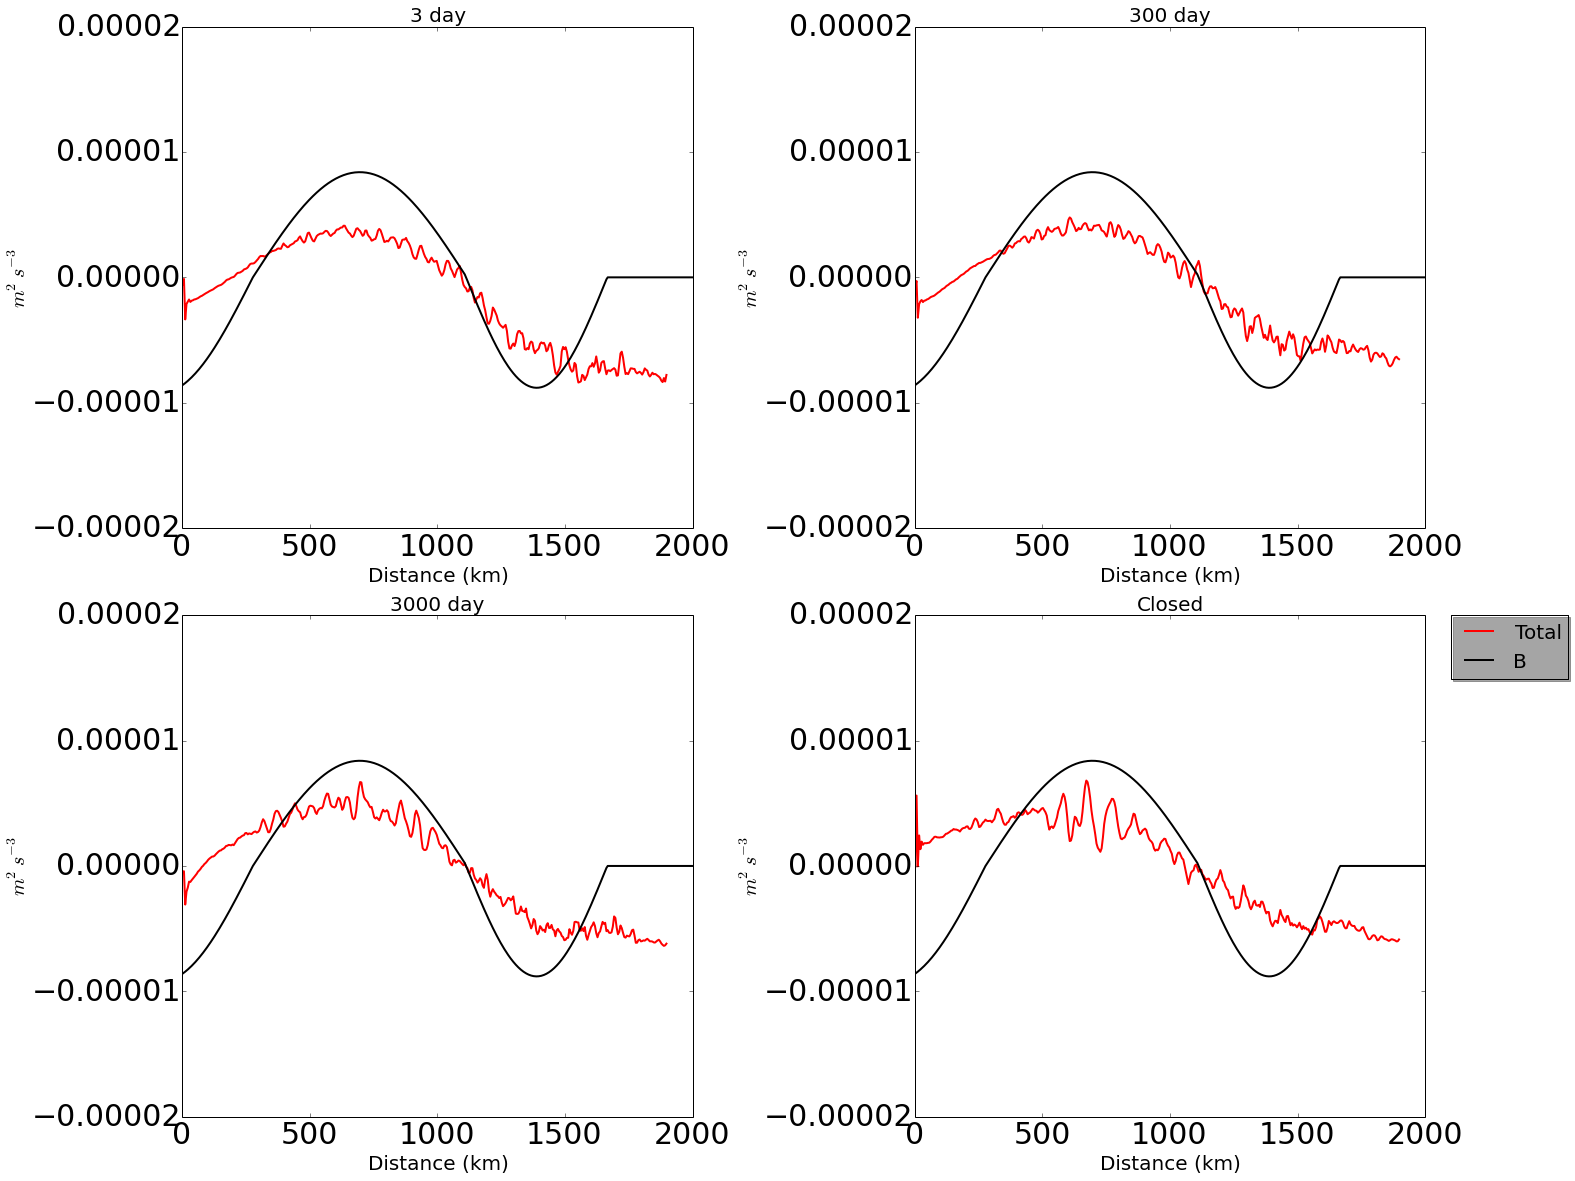

In [78]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTbar.nc','r')
    VTp=fileVTprime.variables['VT'][:]
    fileWTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTbar.nc','r')
    WTp= fileWTprime.variables['WT'][:]
    #fileUTprime= netCDF4.Dataset(gridfilepath+'/UTprimebar.nc','r')
    #UTp= fileUTprime.variables['UT'][:]
    filetav= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav= filetav.variables['VVEL'][:]
    VTav=np.mean(VTav,axis=0)
    #UTav= filetav.variables['UVEL'][:]
    #UTav=np.squeeze(UTav)
    TTav = filetav.variables['THETA'][:]
    TTav = np.mean(TTav,axis=0)-4.0
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad=((0,0),(0,1),(0,0),(0,0))
    WTav=np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav=hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty/5000
    WTMz = WTav.mean(axis=2)*Tz
    VTpz, VTpy = np.gradient(VTp.mean(axis=2),5000)
    #UTpz, UTpy, UTpx = np.gradient(UTp,5000)
    WTpz,WTpy = np.gradient(WTp.mean(axis=2))
    WTMZ=-WTMz/Zmatrix
    WTpZ=-WTpz/Zmatrix
    B=-((VTMy+WTMZ+VTpy+WTpZ)*G*alpha)*Zmatrix
    #B[abs(B)<3*10**-10]=np.nan
    if Full=='N':
        ax = fig.add_subplot(2, 2, i+1)
        #plot(Yc/1000,sum(WTpZ*G*alpha*Zmatrix,axis=0),'b',linewidth=2)
        #plot(Yc/1000,sum(VTpy*G*alpha*Zmatrix,axis=0),'r',linewidth=2)
        plt.plot(Yc[0:-20]/1000,np.sum((VTpy+WTpZ)*Zmatrix,axis=0)[0:-20],'r',linewidth=2)
        plt.plot(Yc/1000,10*Psipred,'k',linewidth=2)
        plt.ylim(-2*10**-5,2.0*10**-5)
        ax.set_title(str(tau[Runs[i]])+' day',fontsize=20)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]),fontsize=20)
    ax.set_xlabel('Distance (km)',fontsize=20)
    ax.set_ylabel('$m^2s^{-3}$',fontsize=20)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'Total',r'B'], shadow=True,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

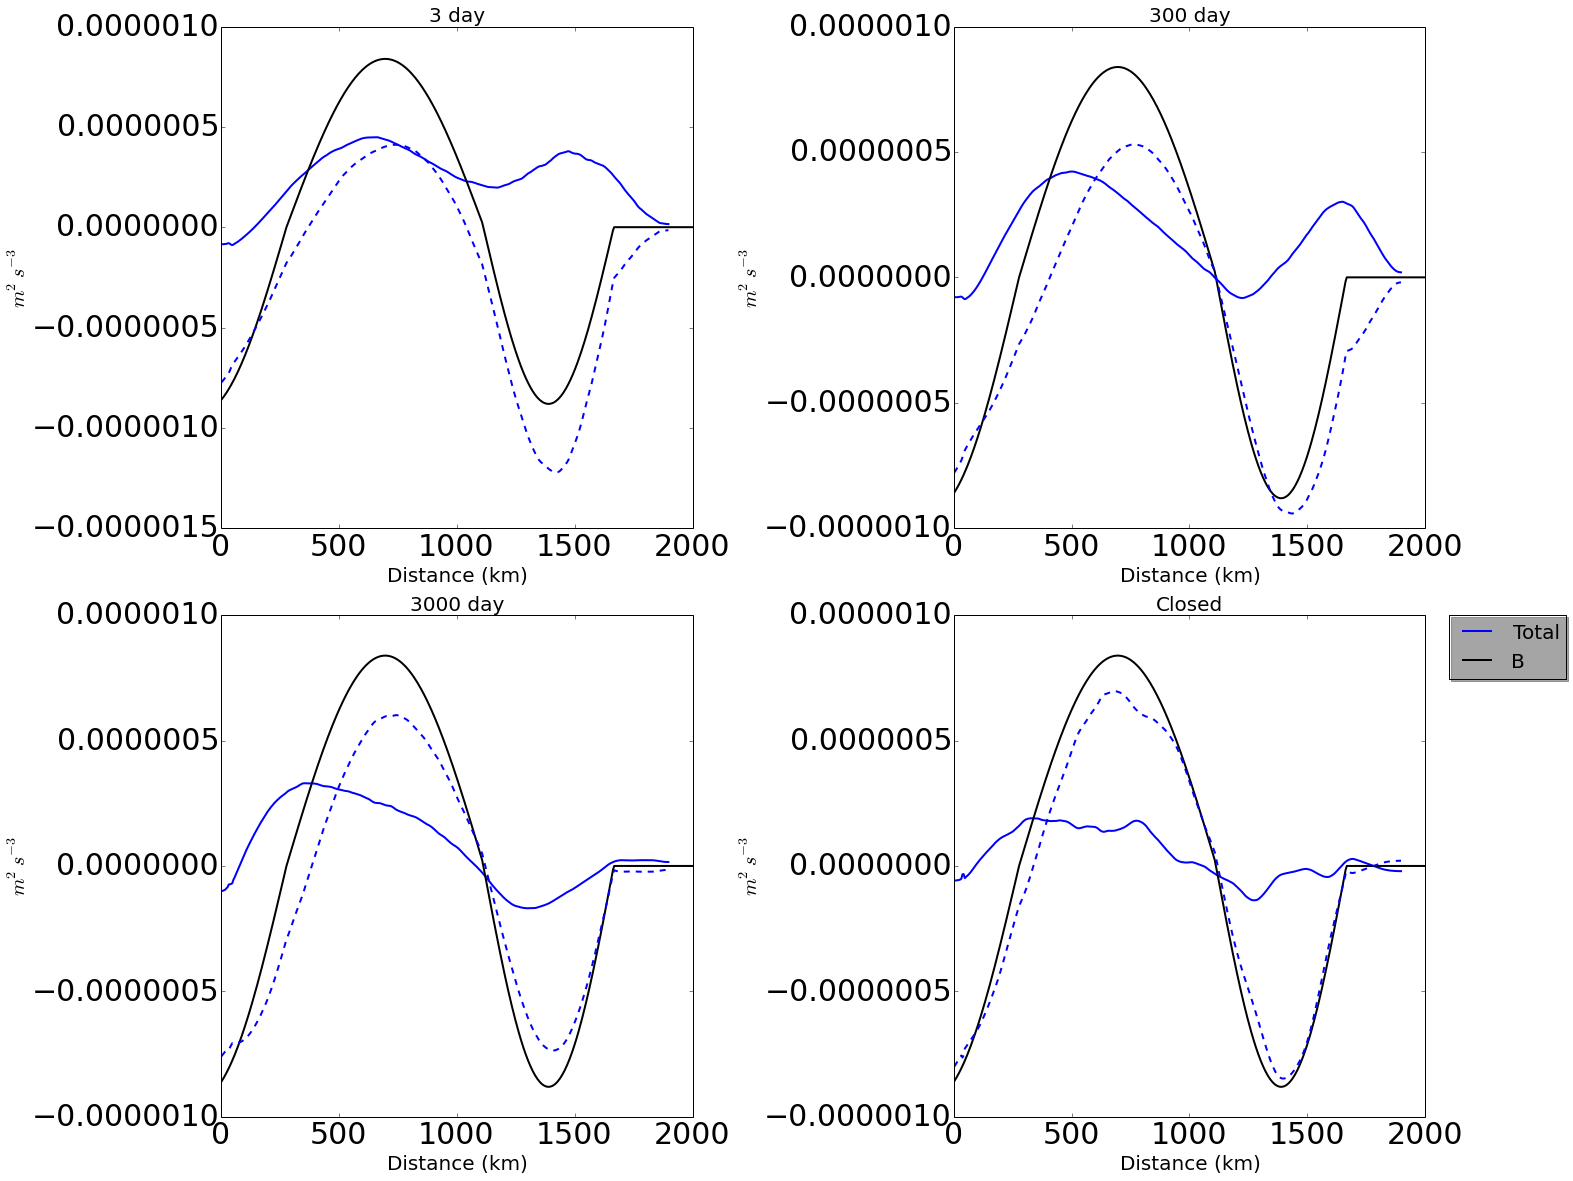

In [68]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    # Load Variables 
    fileVTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/VTprimebar.nc','r')
    VTp=fileVTprime.variables['VT'][:]
    fileWTprime= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp= fileWTprime.variables['WT'][:]
    #fileUTprime= netCDF4.Dataset(gridfilepath+'/UTprimebar.nc','r')
    #UTp= fileUTprime.variables['UT'][:]
    filetav= netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav= filetav.variables['VVEL'][:]
    VTav=np.mean(VTav,axis=0)
    #UTav= filetav.variables['UVEL'][:]
    #UTav=np.squeeze(UTav)
    TTav = filetav.variables['THETA'][:]
    TTav = np.mean(TTav,axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    else:
        TTav = TTav-4.0
    fileWTav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTav.nc','r')
    WTav = fileWTav.variables['WVEL'][:]
    npad=((0,0),(0,1),(0,0),(0,0))
    WTav=np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    WTav=hb.numba_regridz(WTav)
    WTav = np.squeeze(WTav)
    # Terms LHS: VTMy, VTpy, WTMz, WTpz
    # Terms RHS: Psipred (Q), Diff
    Tz,Ty = np.gradient(TTav.mean(axis=2))
    VTMy = hb.numba_regridy(VTav).mean(axis=2)*Ty/5000
    WTMz = WTav.mean(axis=2)*Tz
    VTpz, VTpy = np.gradient(VTp.mean(axis=2),5000)
    #UTpz, UTpy, UTpx = np.gradient(UTp,5000)
    WTpz,WTpy = np.gradient(WTp.mean(axis=2))
    WTMZ=-WTMz/Zmatrix
    WTpZ=-WTpz/Zmatrix
    B=((VTMy+WTMZ+VTpy+WTpZ))
    if Full=='N':
        ax = fig.add_subplot(2, 2, i+1)
        plt.plot(Yc[0:-20]/1000,SG.savitzky_golay(np.sum(B,axis=0)[0:-20],15,1),'b',linewidth=2)
        plt.plot(Yc/1000,Psipred,'k',linewidth=2)
        plt.plot(Yc[0:-20]/1000,Psipred[0:-20]-SG.savitzky_golay(np.sum(B,axis=0)[0:-20],15,1),'--b',linewidth=2)
#        ylim(-1*10**-8,1.0*10**-8)
        ax.set_title(str(tau[Runs[i]])+' day',fontsize=20)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]),fontsize=20)
    ax.set_xlabel('Distance (km)',fontsize=20)
    ax.set_ylabel('$m^2s^{-3}$',fontsize=20)
    ax.tick_params(labelsize=30)
lgd=plt.legend([r'Total',r'B'], shadow=True,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()